# Data analysis

In [1]:
import json
import sys
import networkx
import pandas
import numpy

import matplotlib.pyplot as plotter
from pathlib import Path
from IPython.display import display, HTML

Data dir containing all files

In [2]:
!ls -la /home/ashinde/PhD/CaffineBravery/

total 52
drwxr-xr-x 22 ashinde ashinde 4096 Feb 23 17:51 .
drwxrwxr-x  6 ashinde ashinde   84 Dec  7 19:05 ..
drwxr-xr-x  7 ashinde ashinde  124 Nov 15 11:34 app
drwxr-xr-x  4 ashinde ashinde  142 Oct 15 15:33 domains
drwxr-xr-x  8 ashinde ashinde  220 Feb 16 16:13 .git
-rw-r--r--  1 ashinde ashinde  154 May 24  2022 .gitattributes
-rw-r--r--  1 ashinde ashinde  129 May 24  2022 .gitignore
drwxrwxr-x  6 ashinde ashinde   73 Jun  7  2022 .gradle
drwxr-xr-x  3 ashinde ashinde   21 May 24  2022 gradle
-rwxr-xr-x  1 ashinde ashinde 5774 May 24  2022 gradlew
-rw-r--r--  1 ashinde ashinde 2763 May 24  2022 gradlew.bat
drwxrwxr-x  2 ashinde ashinde   52 Jul 19  2022 policies
-rw-rw-r--  1 ashinde ashinde  743 Jun  7  2022 .project
drwxrwxr-x  2 ashinde ashinde   62 Nov 29 12:57 results
drwxrwxr-x  2 ashinde ashinde  101 Feb  1 18:21 results_l1_active
drwxrwxr-x  2 ashinde ashinde  108 Feb 16 15:17 results_l1_active_control
drwxrwxr-x  2 ashinde ashinde  100 Nov 29 21:44 results_l1_active_crit

In [3]:
# Data files
data_dir = Path("/home/ashinde/PhD/CaffineBravery/results_l2_active/")
data_files = list(data_dir.iterdir())

graph_files = list(filter(lambda x: "pol_graph" in str(x), data_files))
print(f"Policy graph files: {graph_files}")

trace_file = list(filter(lambda x: "trace" in str(x), data_files))[0]
print(f"Trace file: {trace_file}")

Policy graph files: [PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_active/2059461664_attl0_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_active/1221981006_attl0_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_active/1048712791_defl1_active_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_active/1423016050_defl1_passive_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_active/1765900922_attl2_pol_graph.json')]
Trace file: /home/ashinde/PhD/CaffineBravery/results_l2_active/trace.json


In [4]:
def load_json(fname):

    data = None

    with open(fname) as f:
        data = json.load(f)

    return data

In [5]:
# Draw policy graphs
import graphviz


def get_edge_map(edges):
    start = 0
    edge_map = {}
    multi_edge_map = {}
    
    for src, children in edges.items():
        for obs, child in children.items():
            
            # index this observation if not already done
            if obs not in edge_map.keys():
                edge_map[obs] = start
                start += 1
                
            # Add obs to (src, dst) key
            if (src, child) not in multi_edge_map.keys():
                multi_edge_map[(src, child)] = [edge_map[obs]]
            
            else:
                _l = multi_edge_map[(src, child)]
                _l.append(edge_map[obs])
                multi_edge_map[(src, child)] = _l
                
    return edge_map, multi_edge_map


def get_graphviz_graph(json_data):
    
    # initialize empty graph
    G = graphviz.Digraph()
    
    nodes = json_data["nodes"]
    edges = json_data["edges"]
    
    edge_map, multi_edge_map = get_edge_map(edges)
    print(f"Edge map is:")
    for e, i in edge_map.items():
        print(f"{i}:{e}")

    for k, v in nodes.items():
        l = v["act"] + "_start" if "start" in v.keys() else v["act"]
        G.node(k, label=l, fontsize="12")
        
    for s, t in multi_edge_map.keys():
        G.edge(s, t, label=str(multi_edge_map[(s, t)]))
        
    return G

---
## Plot policy graphs

Displaying /home/ashinde/PhD/CaffineBravery/results_l2_active/2059461664_attl0_pol_graph.json
Edge map is:
0:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, failure), (ConnStatus, active)]
1:[(AccessPerm, auth), (HostObs, none), (ActionResult, success), (ConnStatus, active)]
2:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, success), (ConnStatus, active)]
3:[(AccessPerm, denied), (HostObs, none), (ActionResult, failure), (ConnStatus, active)]
4:[(AccessPerm, denied), (HostObs, none), (ActionResult, success), (ConnStatus, active)]
5:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, failure), (ConnStatus, active)]
6:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, success), (ConnStatus, active)]
7:[(AccessPerm, auth), (HostObs, none), (ActionResult, failure), (ConnStatus, active)]
8:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, success), (ConnStatus, terminated)]
9:[(AccessPerm, denied), (HostObs, none), (ActionResult, failure),

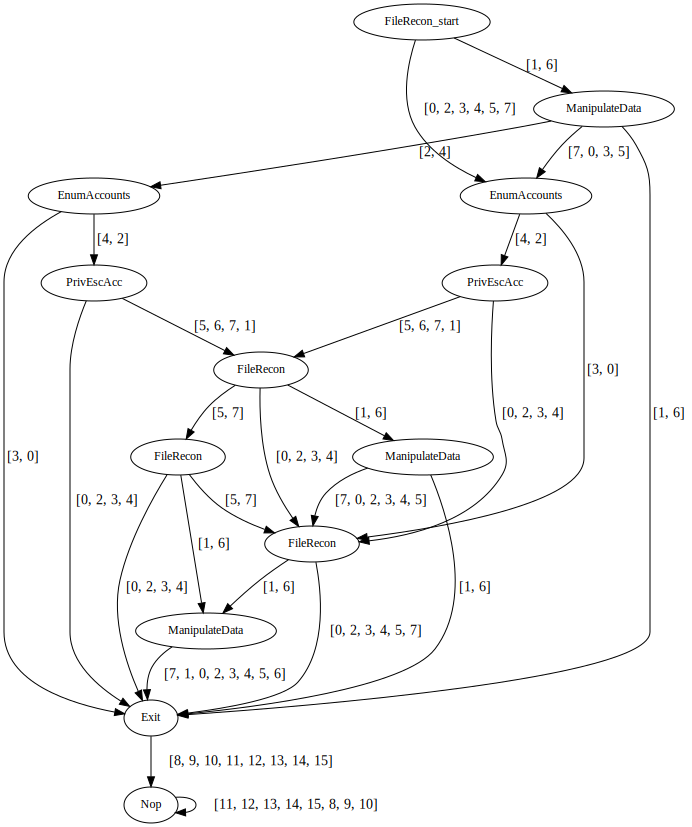

Displaying /home/ashinde/PhD/CaffineBravery/results_l2_active/1221981006_attl0_pol_graph.json
Edge map is:
0:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, failure), (ConnStatus, active)]
1:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, success), (ConnStatus, active)]
2:[(AccessPerm, auth), (HostObs, none), (ActionResult, failure), (ConnStatus, active)]
3:[(AccessPerm, auth), (HostObs, none), (ActionResult, success), (ConnStatus, active)]
4:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, failure), (ConnStatus, active)]
5:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, success), (ConnStatus, active)]
6:[(AccessPerm, denied), (HostObs, none), (ActionResult, failure), (ConnStatus, active)]
7:[(AccessPerm, denied), (HostObs, none), (ActionResult, success), (ConnStatus, active)]
8:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, success), (ConnStatus, terminated)]
9:[(AccessPerm, denied), (HostObs, none), (ActionResult, failure),

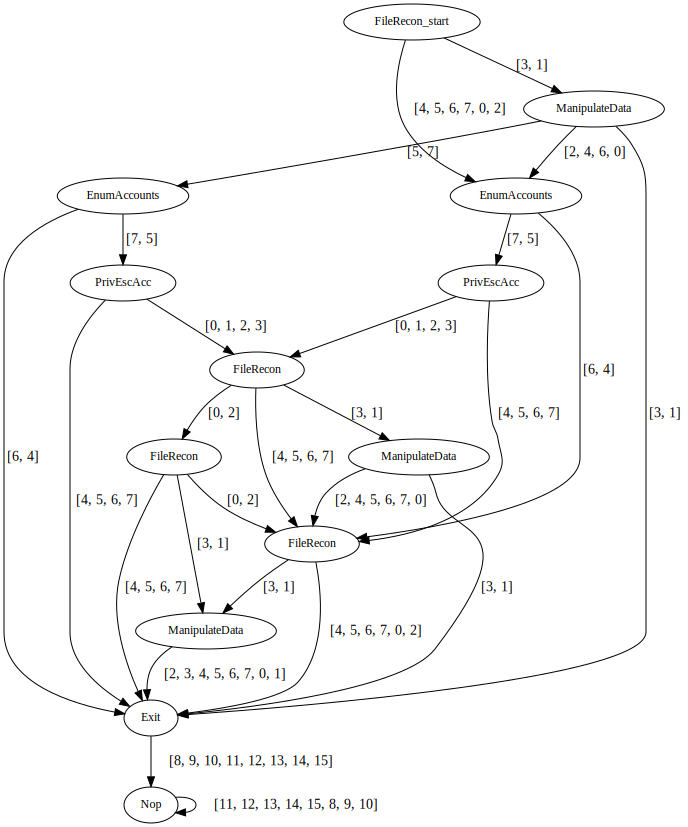

Displaying /home/ashinde/PhD/CaffineBravery/results_l2_active/1048712791_defl1_active_pol_graph.json
Edge map is:
0:[(EndPtAlerts, file_enum)]
1:[(EndPtAlerts, file_write)]
2:[(EndPtAlerts, login_activity)]
3:[(EndPtAlerts, none)]


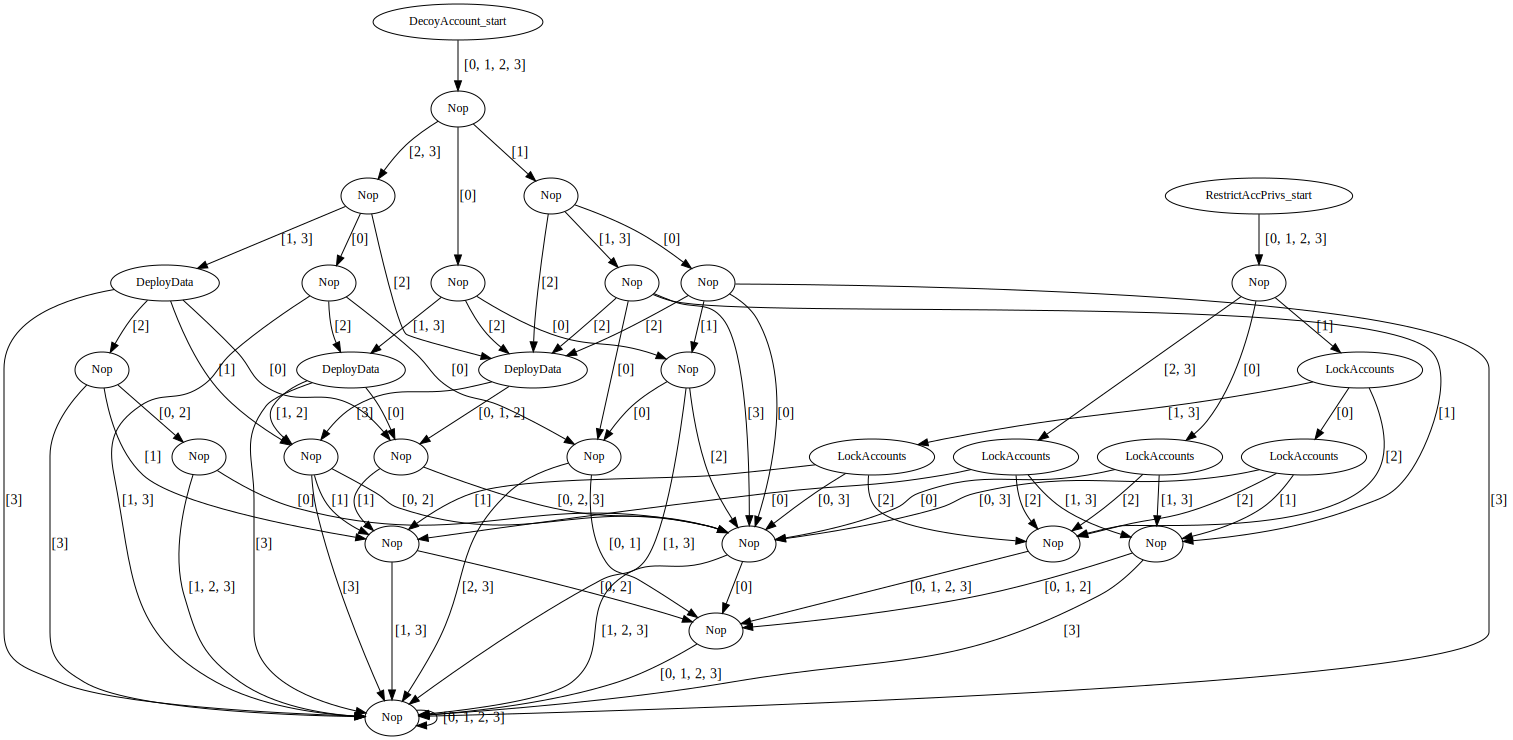

Displaying /home/ashinde/PhD/CaffineBravery/results_l2_active/1423016050_defl1_passive_pol_graph.json
Edge map is:
0:[(EndPtAlerts, file_enum)]
1:[(EndPtAlerts, file_write)]
2:[(EndPtAlerts, login_activity)]
3:[(EndPtAlerts, none)]


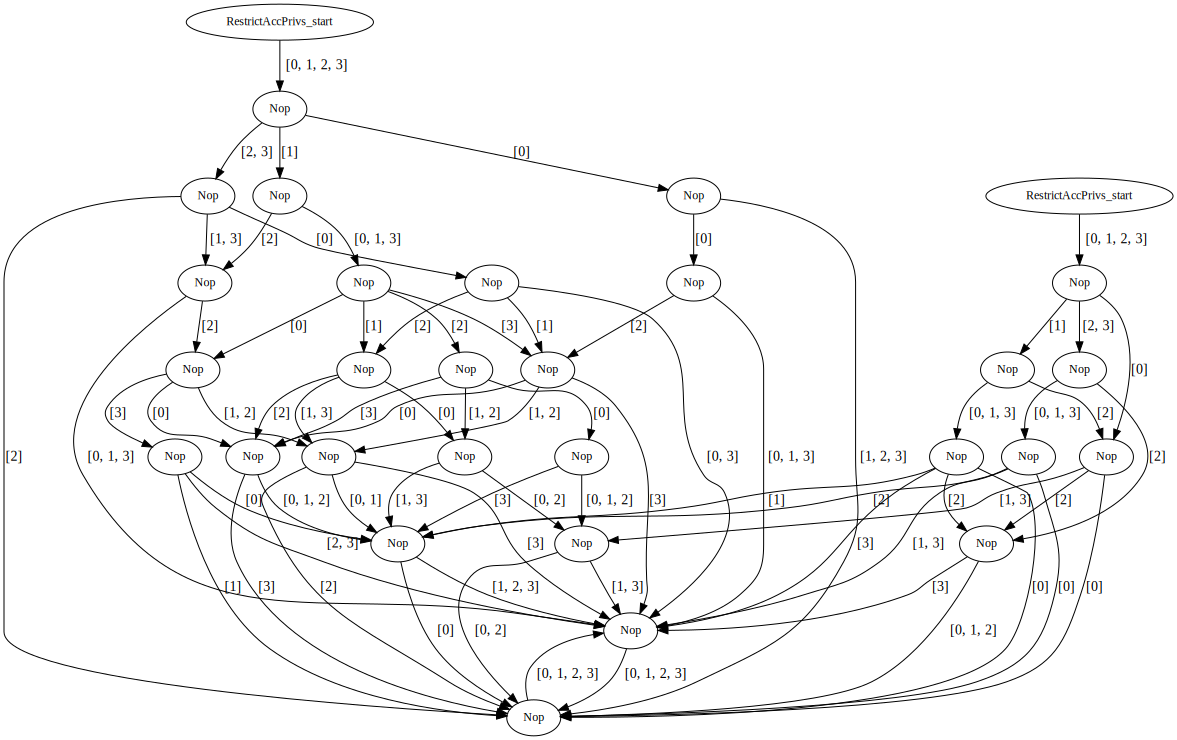

Displaying /home/ashinde/PhD/CaffineBravery/results_l2_active/1765900922_attl2_pol_graph.json
Edge map is:
0:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, failure), (ConnStatus, terminated), (DefenseObs, none)]
1:[(AccessPerm, auth), (HostObs, none), (ActionResult, failure), (ConnStatus, terminated), (DefenseObs, none)]
2:[(AccessPerm, denied), (HostObs, user_files), (ActionResult, success), (ConnStatus, terminated), (DefenseObs, none)]
3:[(AccessPerm, auth), (HostObs, none), (ActionResult, success), (ConnStatus, terminated), (DefenseObs, none)]
4:[(AccessPerm, denied), (HostObs, none), (ActionResult, failure), (ConnStatus, terminated), (DefenseObs, none)]
5:[(AccessPerm, denied), (HostObs, none), (ActionResult, success), (ConnStatus, terminated), (DefenseObs, none)]
6:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, failure), (ConnStatus, terminated), (DefenseObs, none)]
7:[(AccessPerm, auth), (HostObs, user_files), (ActionResult, success), (ConnStatus, termin

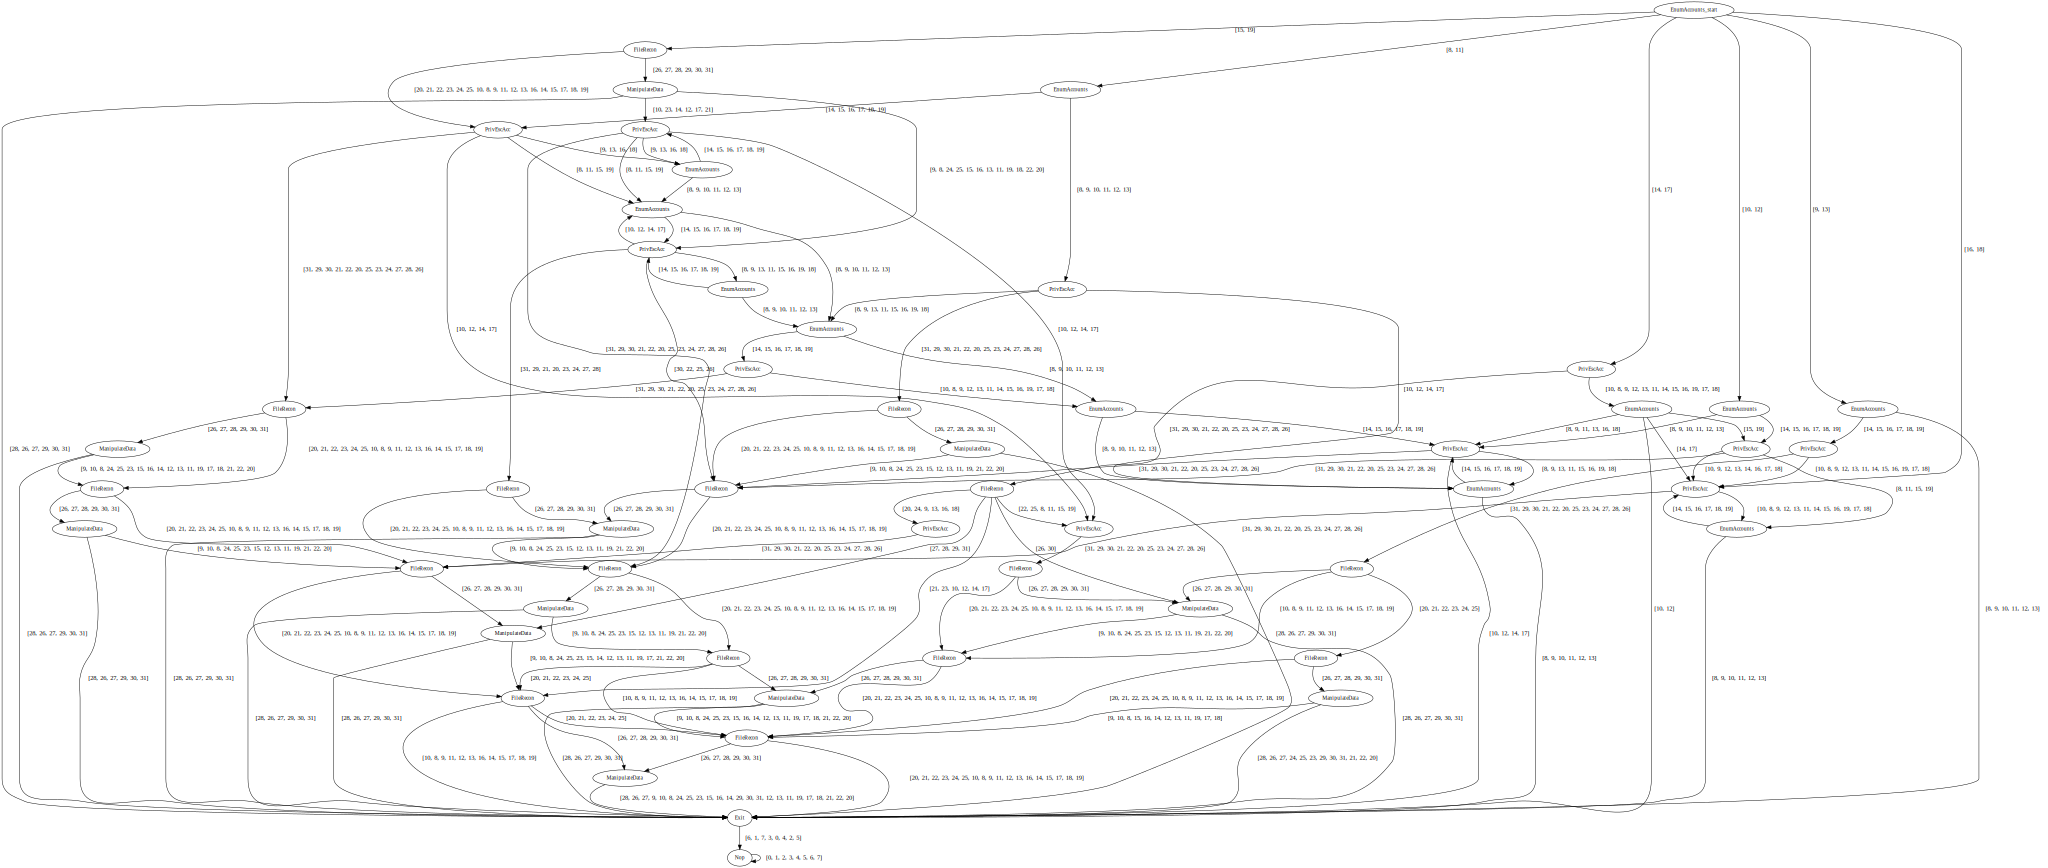

In [6]:
for g in graph_files:
    print(f"Displaying {g}")
    data = load_json(g)
    G = get_graphviz_graph(data)
    display(G)

---
## Beliefs 

In [7]:
import summarize_interaction

# load json data
data = load_json(trace_file)

keys, b_traces = summarize_interaction.get_all_belief_traces(data)

print("Plotting belief divergence over")
for k in keys:
    print(k)

Plotting belief divergence over
('HostType', ['critical', 'critical_honeypot', 'honeypot'])
('HostHasData', ['no', 'yes'])
('DataPrivs', ['root', 'user'])
('EscAccounts', ['no', 'yes'])
('AccFound', ['no', 'yes'])
('DataFound', ['no', 'yes'])
('AccessLevel', ['root', 'user'])
('AttActive', ['no', 'yes'])
('DataInjected', ['no', 'yes'])


Plotting for ('HostType', ['critical', 'critical_honeypot', 'honeypot'])


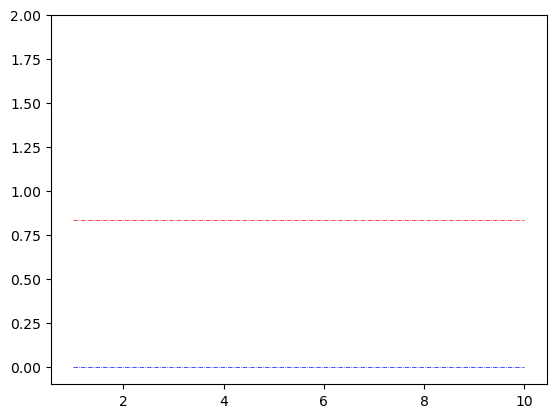

Plotting for ('HostHasData', ['no', 'yes'])


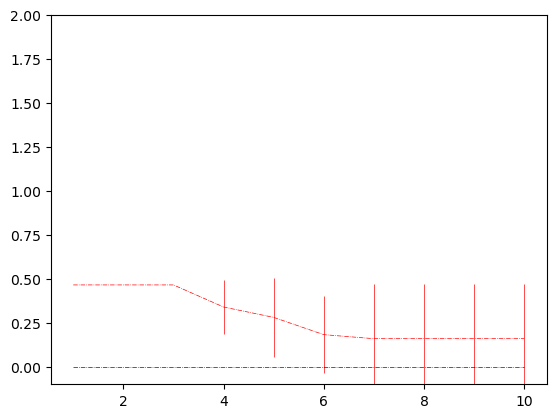

Plotting for ('DataPrivs', ['root', 'user'])


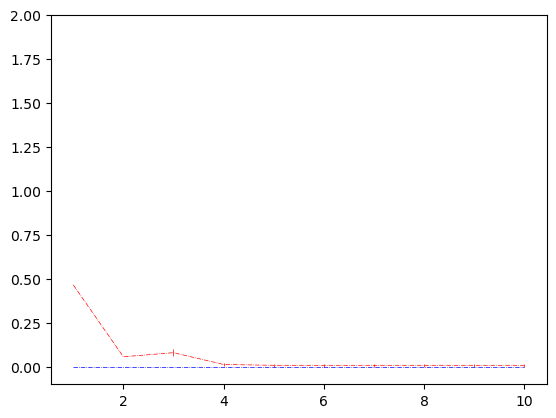

Plotting for ('EscAccounts', ['no', 'yes'])


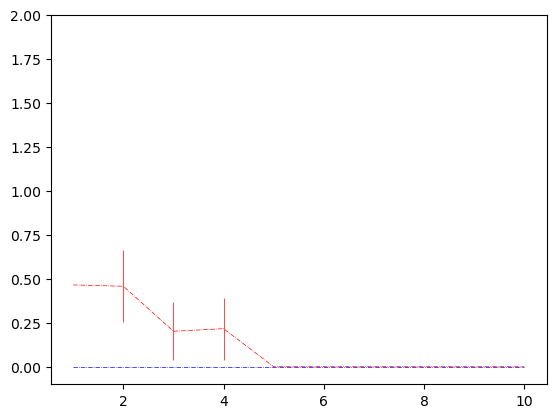

Plotting for ('AccFound', ['no', 'yes'])


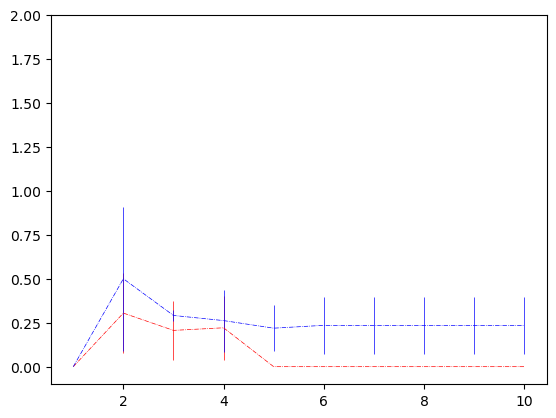

Plotting for ('DataFound', ['no', 'yes'])


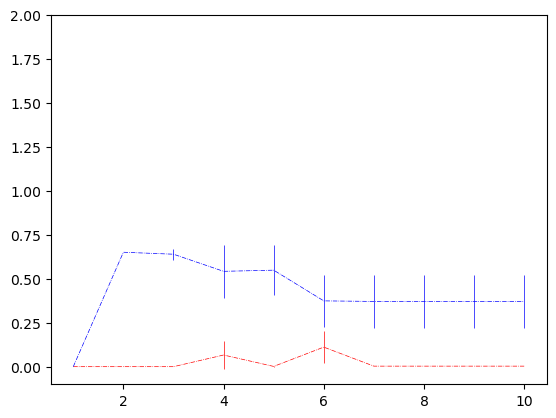

Plotting for ('AccessLevel', ['root', 'user'])


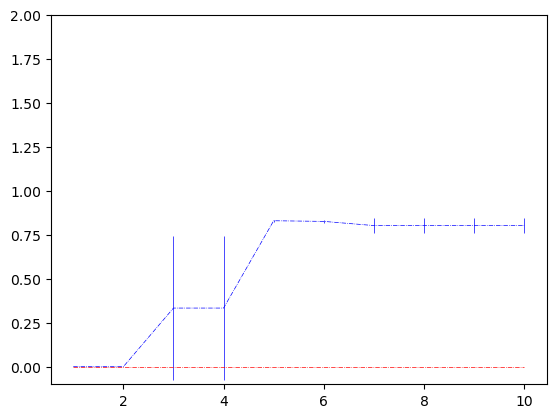

Plotting for ('AttActive', ['no', 'yes'])


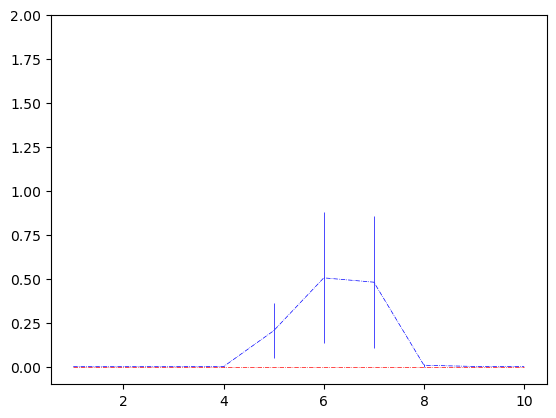

Plotting for ('DataInjected', ['no', 'yes'])


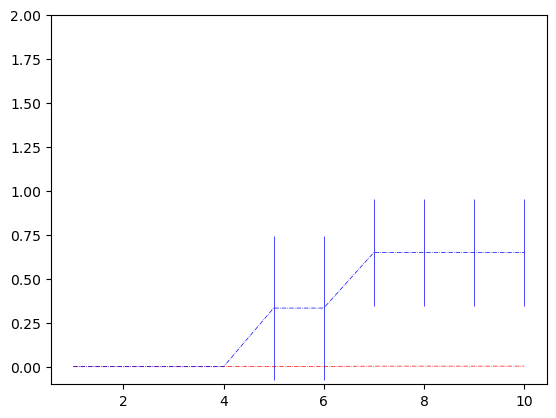

In [8]:
# Get divergence
divs = []
for b_trace in b_traces:
    divs.append(summarize_interaction.get_divergence(b_trace))
    
for i in range(len(keys)):
    print(f"Plotting for {keys[i]}")
    
    i_means = numpy.mean(divs[i][0], axis=0)
    i_dev = numpy.std(divs[i][0], axis=0)
    plotter.errorbar(numpy.linspace(1, i_means.shape[0], i_means.shape[0]), i_means, fmt='r-.', yerr=i_dev, linewidth=0.5)
    
    if len(divs[i]) > 1:
        j_means = numpy.mean(divs[i][1], axis=0)
        j_dev = numpy.std(divs[i][1], axis=0)
        plotter.errorbar(numpy.linspace(1, j_means.shape[0], j_means.shape[0]), j_means, fmt='b-.', yerr=j_dev, linewidth=0.5)
        # plotter.plot(divs[i][1].T, 'b-.', linewidth=0.5)
    
    plotter.ylim(-0.1, 2)
    plotter.show()
    

---
# Display interaction examples

,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,EnumAccounts,denied|user_files|success|active|perms_change,RestrictAccPrivs,file_enum
1,PrivEscAcc,auth|none|success|active|none,Nop,file_write
2,FileRecon,auth|user_files|success|active|acc_policy_change,LockAccounts,file_enum
3,ManipulateData,auth|none|success|active|acc_policy_change,LockAccounts,file_write
4,Exit,denied|none|failure|terminated|none,Nop,none
5,Nop,denied|user_files|failure|terminated|none,Nop,none
6,Nop,auth|user_files|success|terminated|none,Nop,none
7,Nop,auth|none|failure|terminated|none,Nop,none
8,Nop,denied|none|success|terminated|none,Nop,none
9,Nop,denied|none|success|terminated|none,Nop,none


Agent i's P(Aj)


,DecoyAccount,DeployData,LockAccounts,Nop,RestrictAccPrivs
0,0.25,0.000000,0.000000,0.000000,0.75
1,0.00,0.000000,0.000000,1.000000,0.00
2,0.00,0.000000,0.327273,0.672727,0.00
3,0.00,0.000402,0.042632,0.956967,0.00
4,0.00,0.000065,0.000000,0.999935,0.00
5,0.00,0.000000,0.000000,1.000000,0.00
6,0.00,0.000000,0.000000,1.000000,0.00
7,0.00,0.000000,0.000000,1.000000,0.00
8,0.00,0.000000,0.000000,1.000000,0.00
9,0.00,0.000000,0.000000,1.000000,0.00


Agent j's P(Aj)


,EnumAccounts,Exit,FileRecon,ManipulateData,Nop,PrivEscAcc
0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,0.990000,0.000000,0.000000,0.010000,0.000000,0.000000
2,0.146478,0.000073,0.221897,0.000000,0.000000,0.631552
3,0.000000,0.541974,0.185475,0.005251,0.000011,0.267290
4,0.000000,0.248427,0.246452,0.005141,0.499980,0.000000
5,0.000000,0.018442,0.000000,0.000950,0.980609,0.000000
6,0.000000,0.000056,0.000000,0.000000,0.999944,0.000000
7,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


,highCap,lowCap
0,0.500000,0.500000
1,0.345455,0.654545
2,0.345455,0.654545
3,0.900277,0.099723
4,0.942181,0.057819
5,0.942181,0.057819
6,0.942181,0.057819
7,0.942181,0.057819
8,0.942181,0.057819
9,0.942181,0.057819


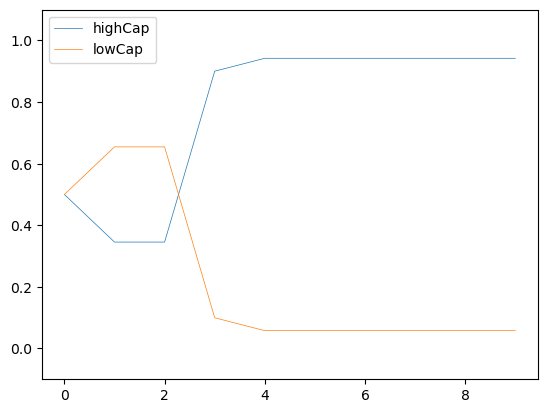

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


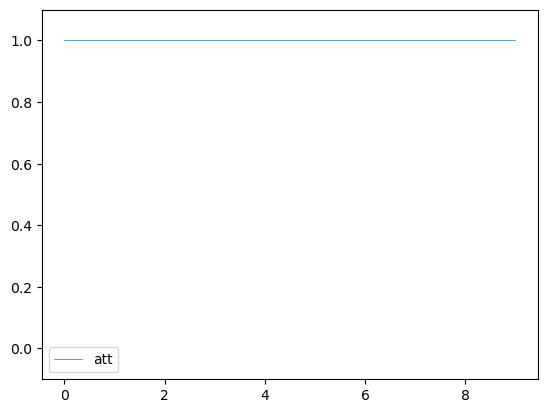

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


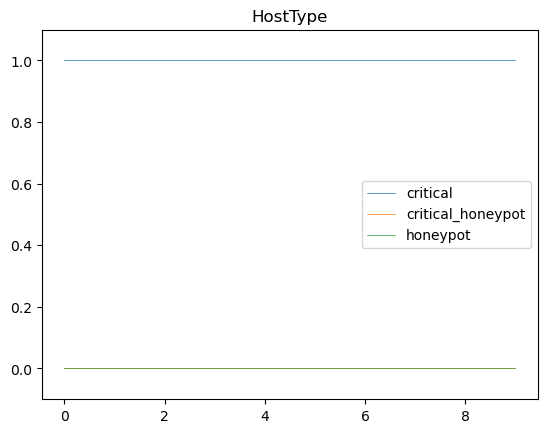

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,0.0,1.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


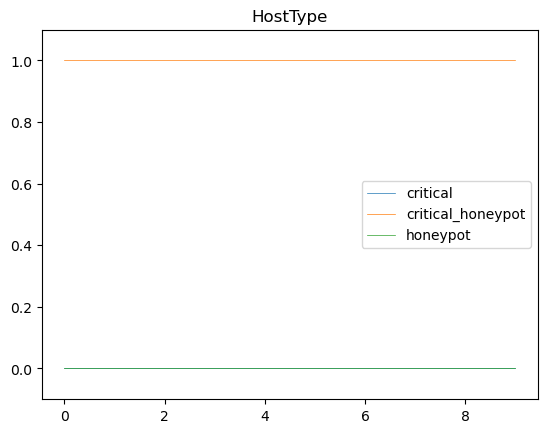

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


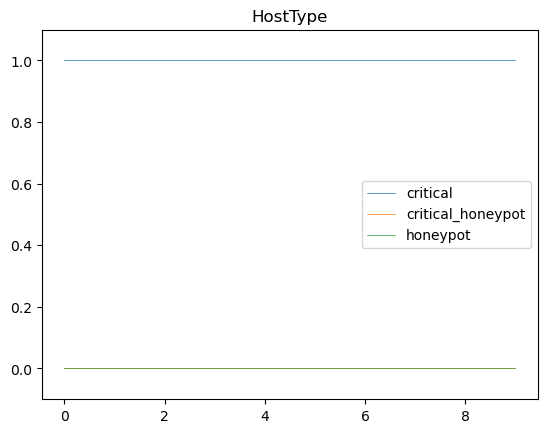

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


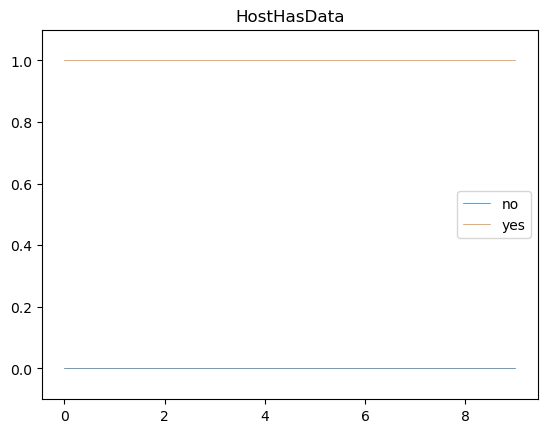

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.500000,0.500000
2,0.500000,0.500000
3,0.064103,0.935897
4,0.000035,0.999965
5,0.000035,0.999965
6,0.000035,0.999965
7,0.000035,0.999965
8,0.000035,0.999965
9,0.000035,0.999965


Plotting ('HostHasData', ['no', 'yes']) for agent_i


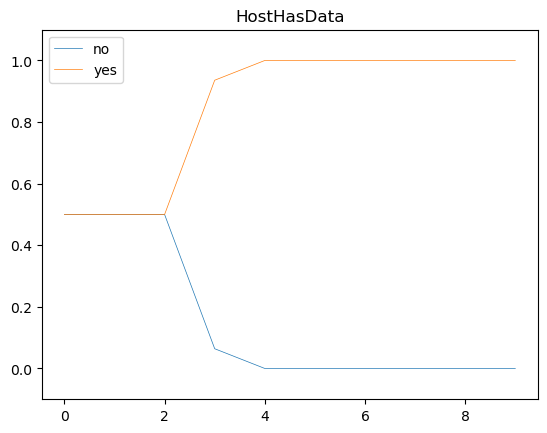

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


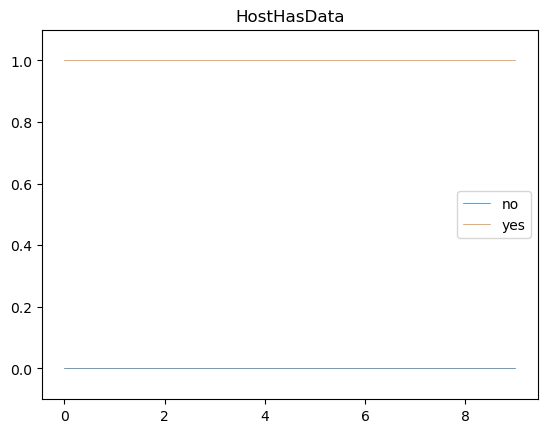

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


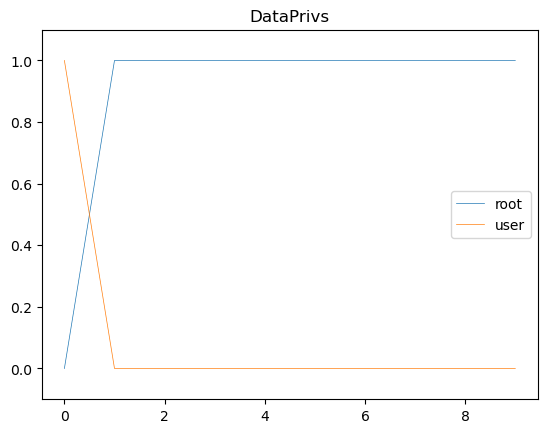

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.500000,0.500000
1,0.990909,0.009091
2,0.990909,0.009091
3,0.998615,0.001385
4,0.999197,0.000803
5,0.999197,0.000803
6,0.999197,0.000803
7,0.999197,0.000803
8,0.999197,0.000803
9,0.999197,0.000803


Plotting ('DataPrivs', ['root', 'user']) for agent_i


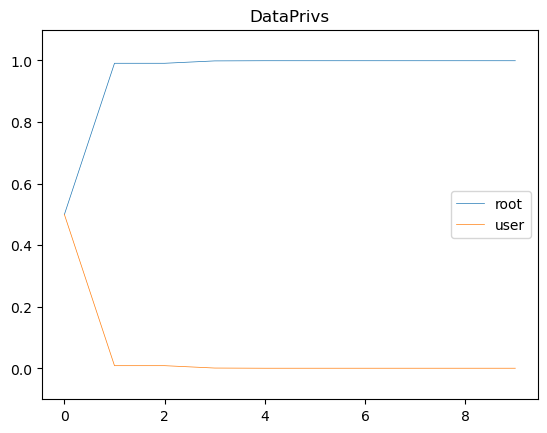

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


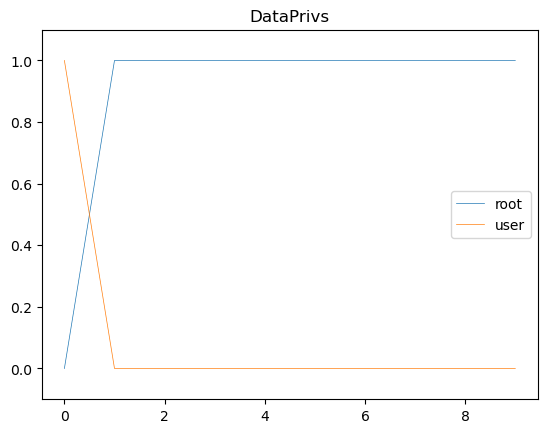

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


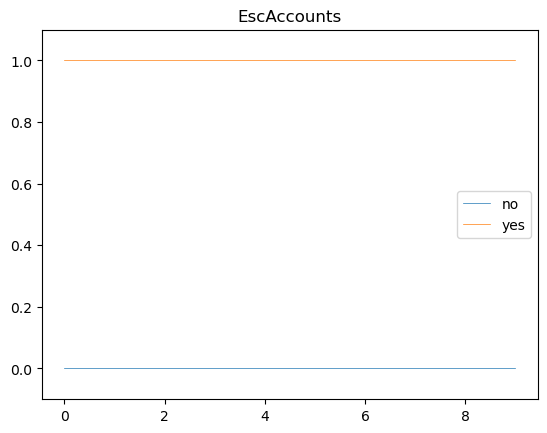

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.116883,0.883117
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000000,1.000000
5,0.000000,1.000000
6,0.000000,1.000000
7,0.000000,1.000000
8,0.000000,1.000000
9,0.000000,1.000000


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


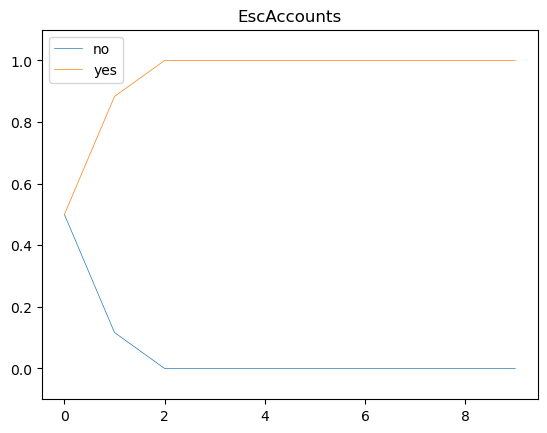

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


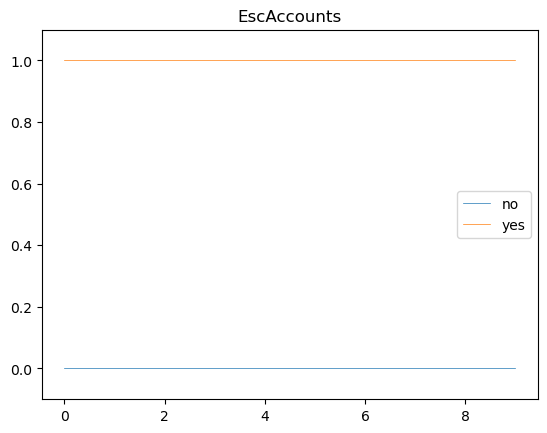

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccFound', ['no', 'yes']) for state:


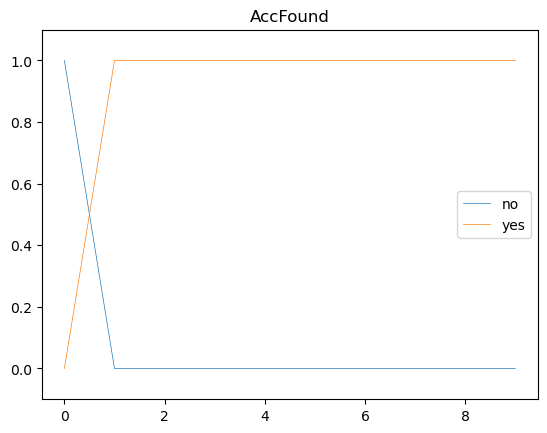

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,0.142857,0.857143
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000000,1.000000
5,0.000000,1.000000
6,0.000000,1.000000
7,0.000000,1.000000
8,0.000000,1.000000
9,0.000000,1.000000


Plotting ('AccFound', ['no', 'yes']) for agent_i


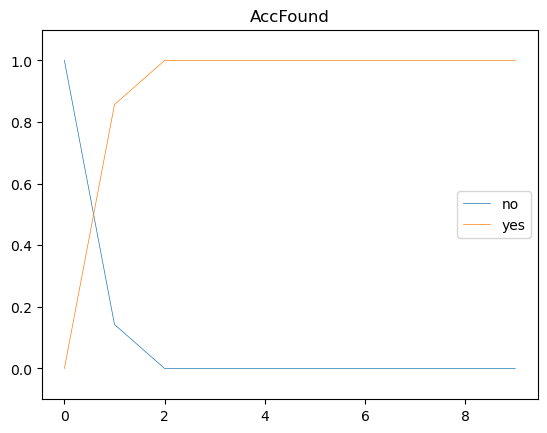

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,0.317241,0.682759
3,0.453542,0.546458
4,0.472047,0.527953
5,0.606567,0.393433
6,0.607085,0.392915
7,0.607085,0.392915
8,0.607085,0.392915
9,0.607085,0.392915


Plotting ('AccFound', ['no', 'yes']) for agent_j


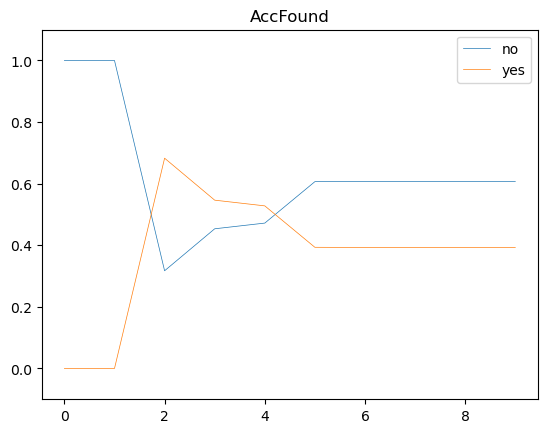

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('DataFound', ['no', 'yes']) for state:


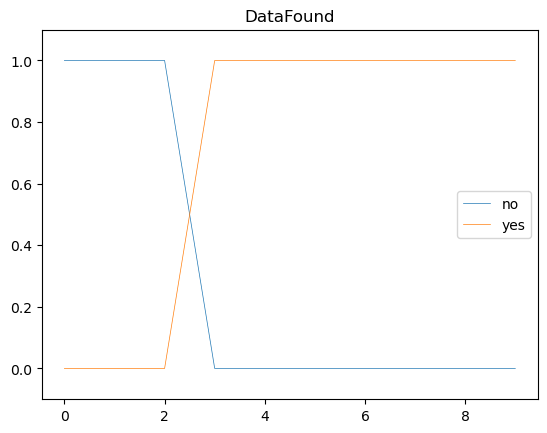

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.076923,0.923077
4,0.000042,0.999958
5,0.000042,0.999958
6,0.000042,0.999958
7,0.000042,0.999958
8,0.000042,0.999958
9,0.000042,0.999958


Plotting ('DataFound', ['no', 'yes']) for agent_i


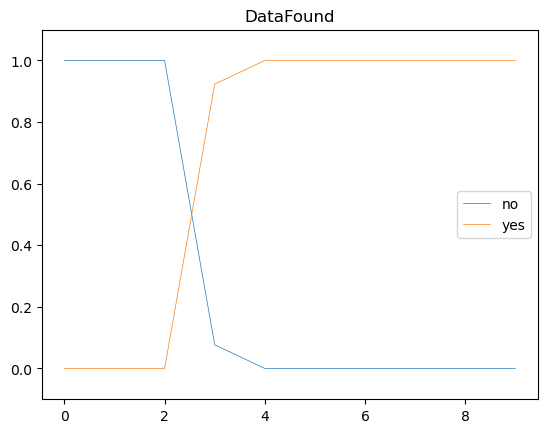

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.310345,0.689655
3,0.483809,0.516191
4,0.523814,0.476186
5,0.376072,0.623928
6,0.375514,0.624486
7,0.375514,0.624486
8,0.375514,0.624486
9,0.375514,0.624486


Plotting ('DataFound', ['no', 'yes']) for agent_j


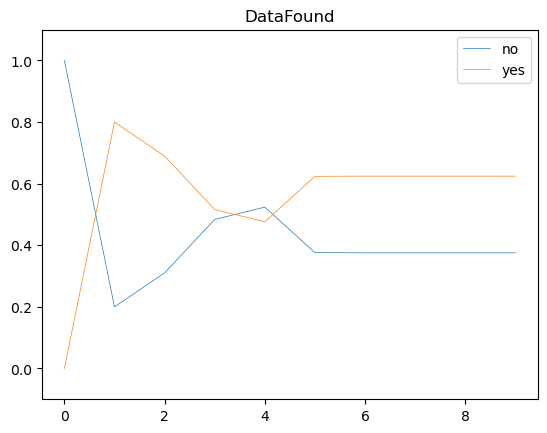

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccessLevel', ['root', 'user']) for state:


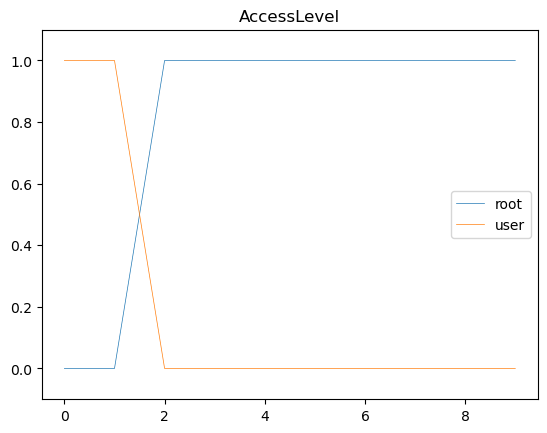

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


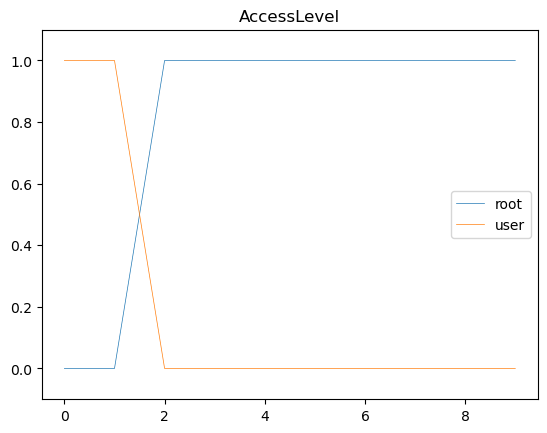

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_j


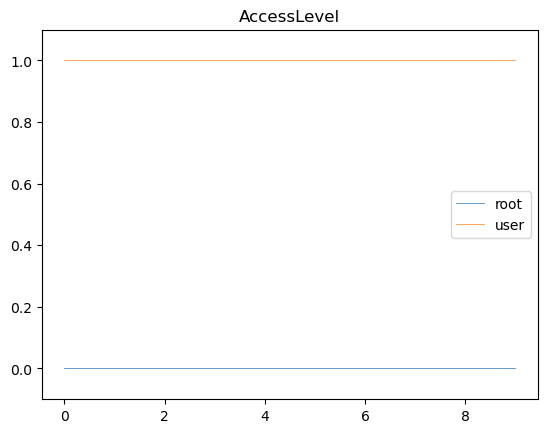

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


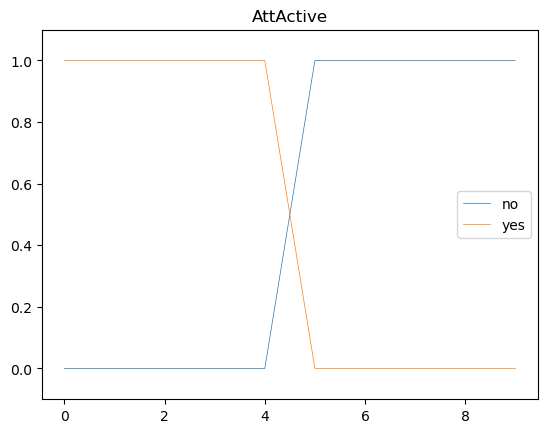

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


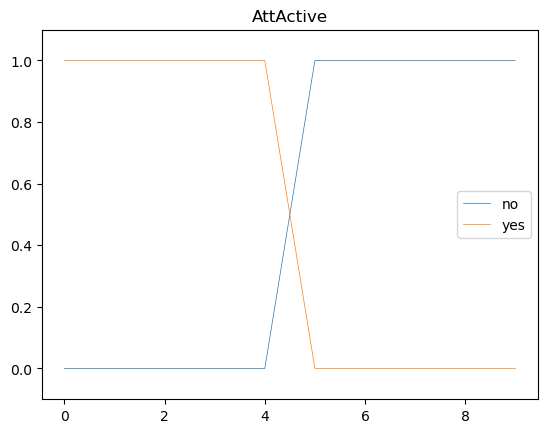

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000011,0.999989
4,0.499980,0.500019
5,0.980609,0.019391
6,0.999944,0.000056
7,1.000000,0.000000
8,1.000000,0.000000
9,1.000000,0.000000


Plotting ('AttActive', ['no', 'yes']) for agent_j


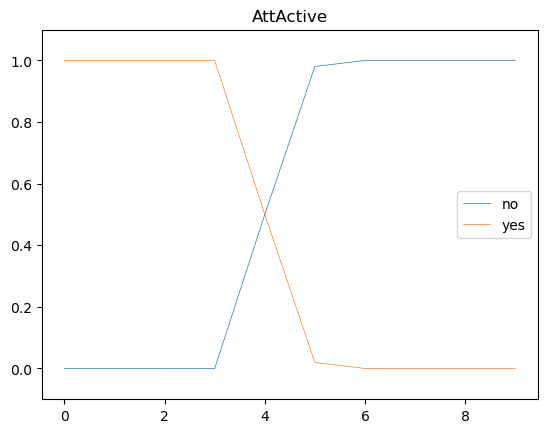

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('DataInjected', ['no', 'yes']) for state:


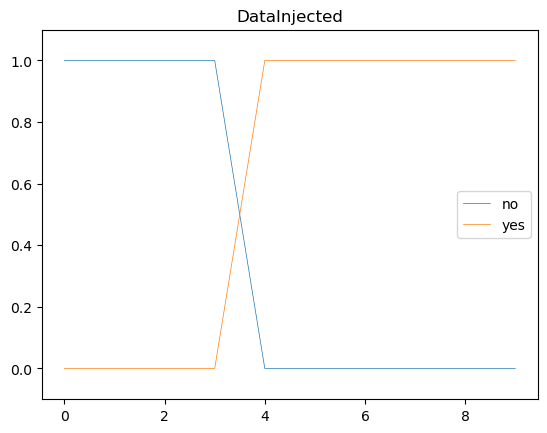

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,0.000042,0.999958
5,0.000042,0.999958
6,0.000042,0.999958
7,0.000042,0.999958
8,0.000042,0.999958
9,0.000042,0.999958


Plotting ('DataInjected', ['no', 'yes']) for agent_i


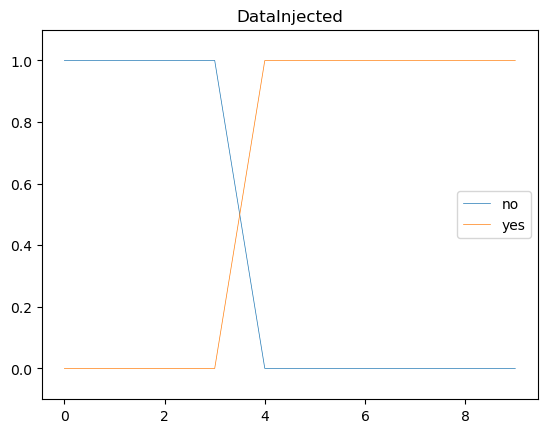

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_j


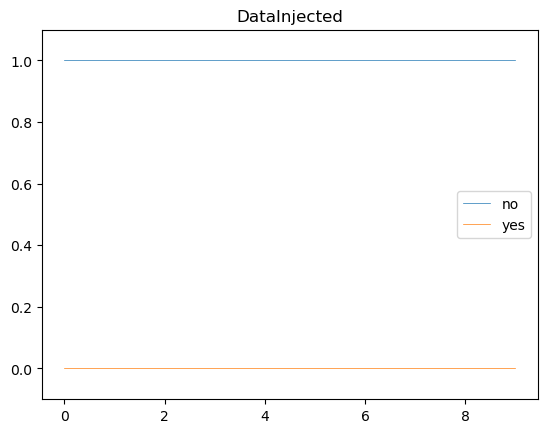

=============== End interaction trace


,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,EnumAccounts,denied|user_files|failure|active|perms_change,RestrictAccPrivs,file_enum
1,EnumAccounts,denied|user_files|success|active|none,Nop,file_enum
2,PrivEscAcc,denied|none|failure|active|acc_policy_change,LockAccounts,login_activity
3,PrivEscAcc,auth|none|failure|active|none,Nop,login_activity
4,FileRecon,auth|none|success|active|acc_policy_change,Nop,file_enum
5,ManipulateData,auth|user_files|success|active|none,Nop,file_write
6,Exit,denied|none|success|terminated|none,Nop,none
7,Nop,auth|none|failure|terminated|none,Nop,none
8,Nop,denied|none|failure|terminated|none,Nop,none
9,Nop,denied|none|success|terminated|none,Nop,file_write


Agent i's P(Aj)


,DecoyAccount,DeployData,LockAccounts,Nop,RestrictAccPrivs
0,0.25,0.000000,0.000000,0.000000,0.75
1,0.00,0.000000,0.000000,1.000000,0.00
2,0.00,0.000000,0.316060,0.683940,0.00
3,0.00,0.000206,0.007243,0.992551,0.00
4,0.00,0.000000,0.000000,1.000000,0.00
5,0.00,0.000000,0.000000,1.000000,0.00
6,0.00,0.000000,0.000000,1.000000,0.00
7,0.00,0.000000,0.000000,1.000000,0.00
8,0.00,0.000000,0.000000,1.000000,0.00
9,0.00,0.000000,0.000000,1.000000,0.00


Agent j's P(Aj)


,EnumAccounts,Exit,FileRecon,ManipulateData,Nop,PrivEscAcc
0,0.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000
1,0.990000,0.000000e+00,0.000000,0.010000,0.000000e+00,0.000000
2,0.000594,2.969122e-07,0.259846,0.000000,0.000000e+00,0.739561
3,0.000000,2.005399e-02,0.979718,0.000194,2.313667e-08,0.000034
4,0.000000,9.699788e-01,0.000582,0.009397,2.004303e-02,0.000000
5,0.000000,9.561405e-03,0.002573,0.006970,9.808956e-01,0.000000
6,0.000000,1.053485e-01,0.001762,0.001806,8.910835e-01,0.000000
7,0.000000,1.323317e-04,0.000000,0.000078,9.997894e-01,0.000000
8,0.000000,4.603662e-06,0.000000,0.000000,9.999955e-01,0.000000
9,0.000000,0.000000e+00,0.000000,0.000000,1.000000e+00,0.000000


,highCap,lowCap
0,0.500000,0.500000
1,0.345455,0.654545
2,0.367880,0.632120
3,0.965976,0.034024
4,1.000000,0.000000
5,1.000000,0.000000
6,1.000000,0.000000
7,1.000000,0.000000
8,1.000000,0.000000
9,1.000000,0.000000


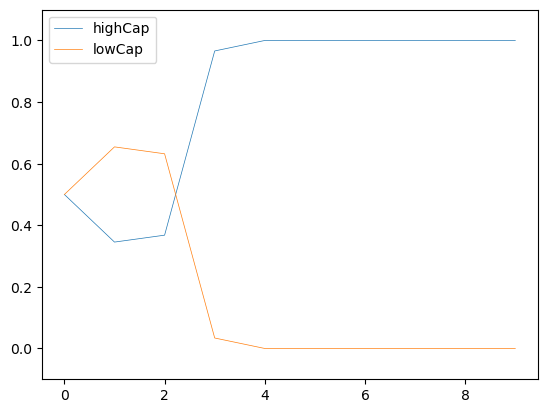

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


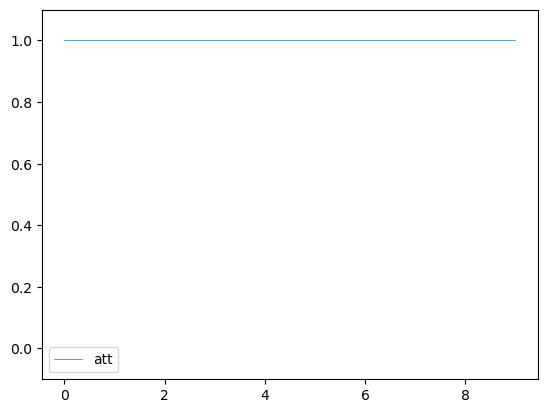

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


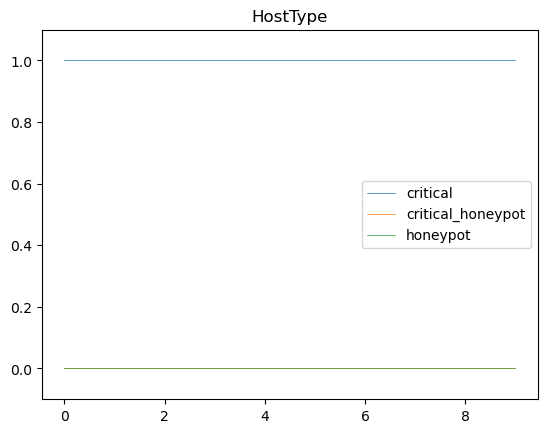

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,0.0,1.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


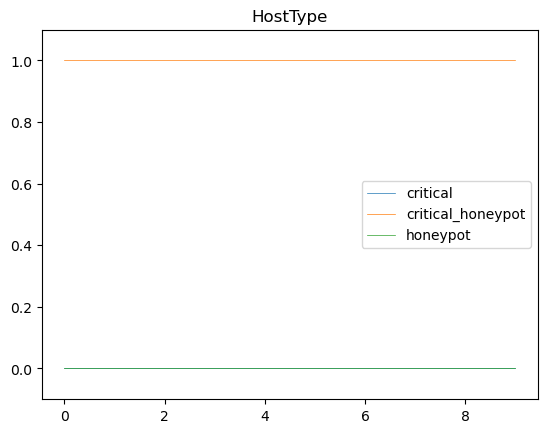

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


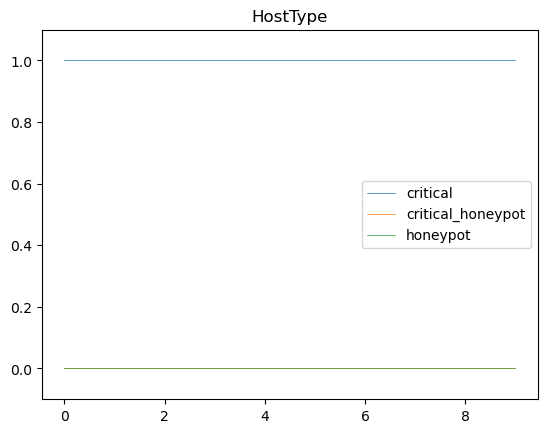

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


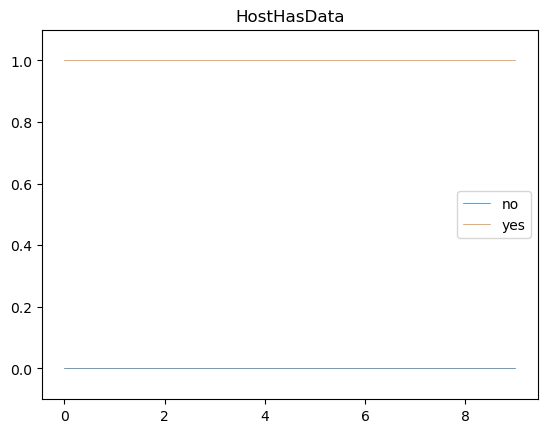

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.500000,0.500000
2,0.500000,0.500000
3,0.500000,0.500000
4,0.500000,0.500000
5,0.064103,0.935898
6,0.000035,0.999965
7,0.000035,0.999965
8,0.000035,0.999965
9,0.000035,0.999965


Plotting ('HostHasData', ['no', 'yes']) for agent_i


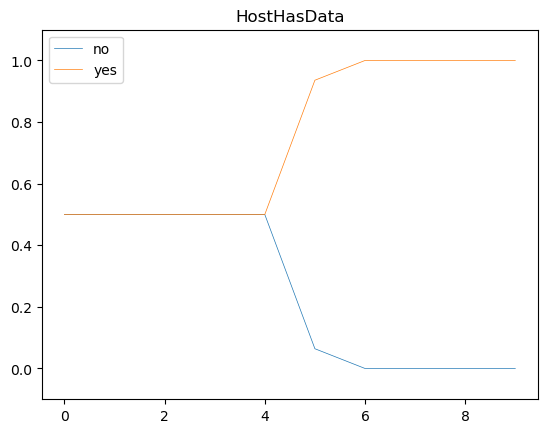

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


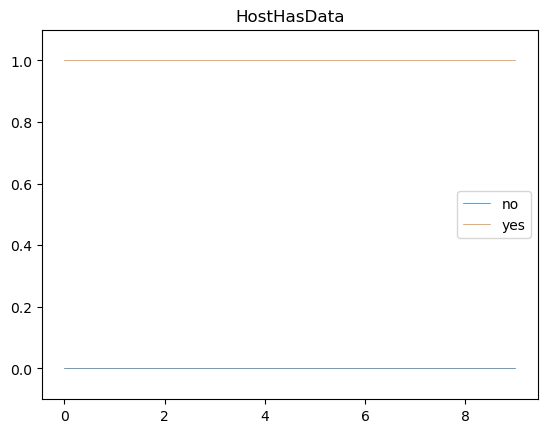

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


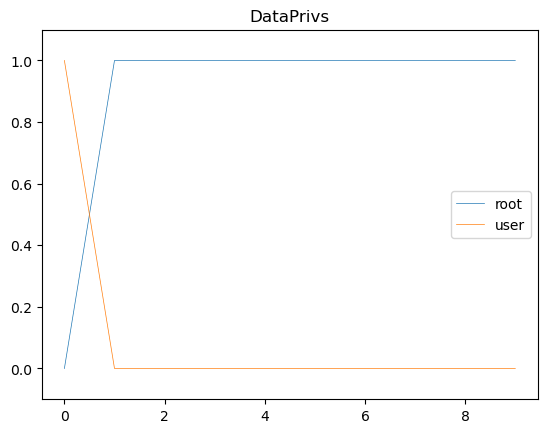

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.500000,0.500000
1,0.990909,0.009091
2,0.974090,0.025910
3,0.999891,0.000109
4,1.000000,0.000000
5,1.000000,0.000000
6,1.000000,0.000000
7,1.000000,0.000000
8,1.000000,0.000000
9,1.000000,0.000000


Plotting ('DataPrivs', ['root', 'user']) for agent_i


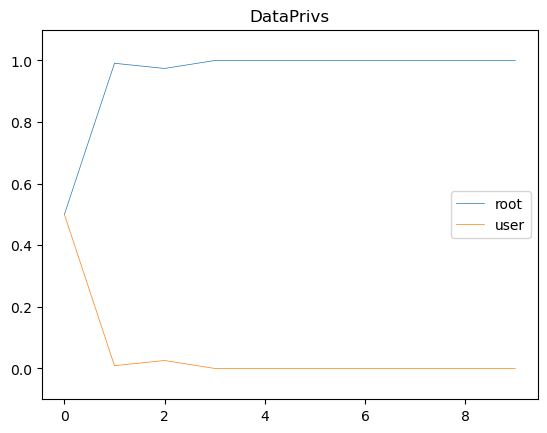

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


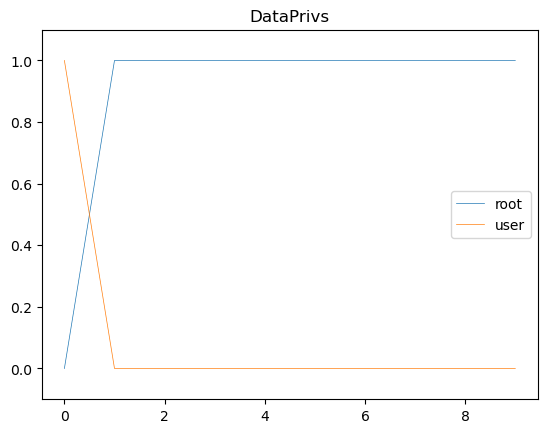

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


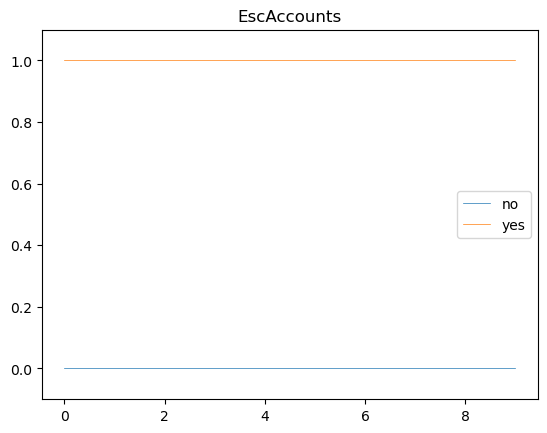

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.761755,0.238244
2,0.289079,0.710921
3,0.327154,0.672846
4,0.000000,1.000000
5,0.000000,1.000000
6,0.000000,1.000000
7,0.000000,1.000000
8,0.000000,1.000000
9,0.000000,1.000000


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


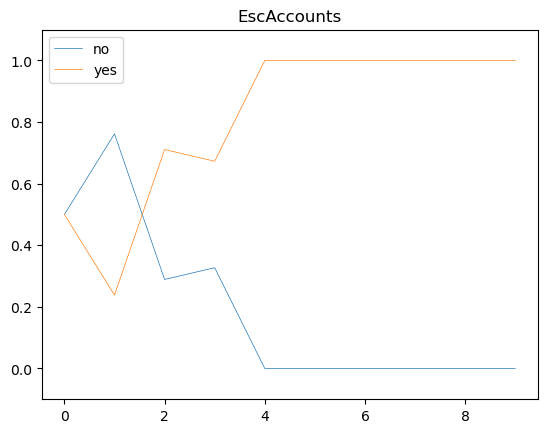

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


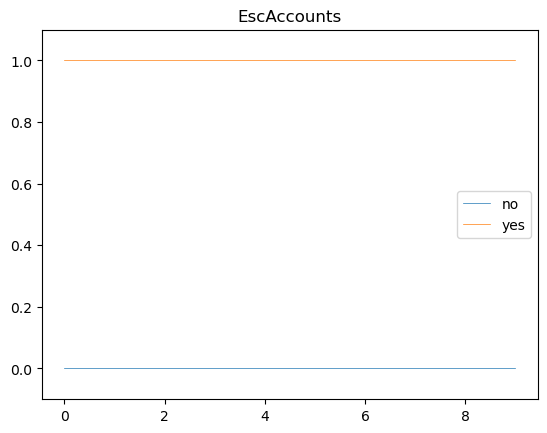

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccFound', ['no', 'yes']) for state:


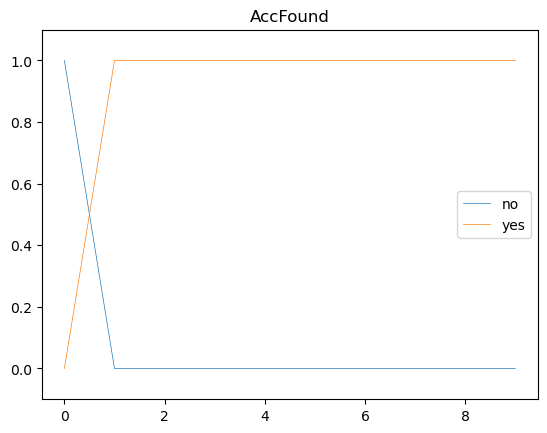

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,0.931034,0.068966
2,0.301927,0.698073
3,0.340458,0.659542
4,0.000000,1.000000
5,0.000000,1.000000
6,0.000000,1.000000
7,0.000000,1.000000
8,0.000000,1.000000
9,0.000000,1.000000


Plotting ('AccFound', ['no', 'yes']) for agent_i


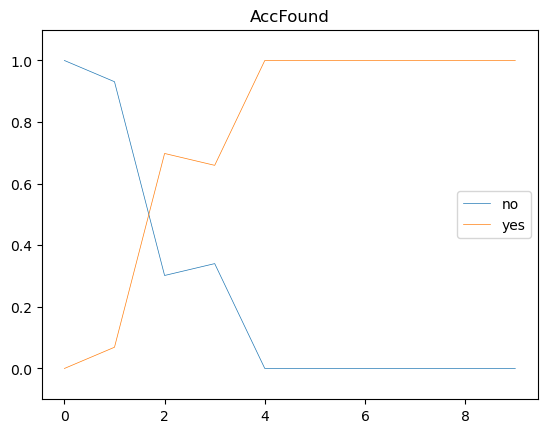

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,0.200475,0.799525
3,0.040506,0.959494
4,0.040498,0.959501
5,0.040374,0.959626
6,0.036514,0.963486
7,0.036637,0.963363
8,0.036640,0.963360
9,0.036640,0.963360


Plotting ('AccFound', ['no', 'yes']) for agent_j


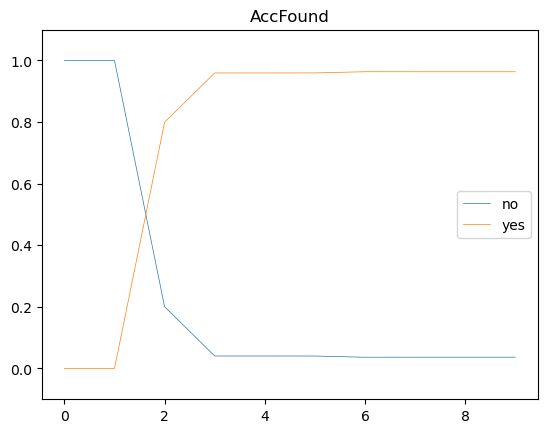

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('DataFound', ['no', 'yes']) for state:


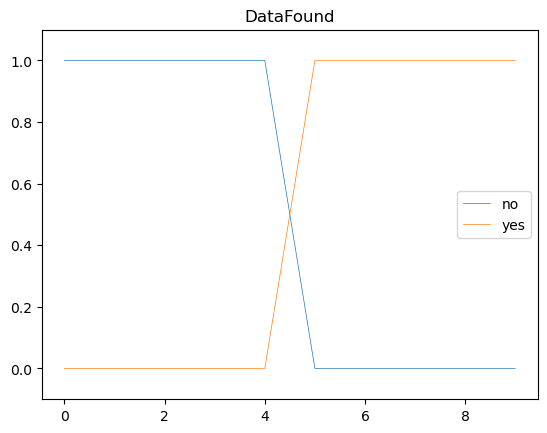

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,0.076923,0.923077
6,0.000042,0.999958
7,0.000042,0.999958
8,0.000042,0.999958
9,0.000042,0.999958


Plotting ('DataFound', ['no', 'yes']) for agent_i


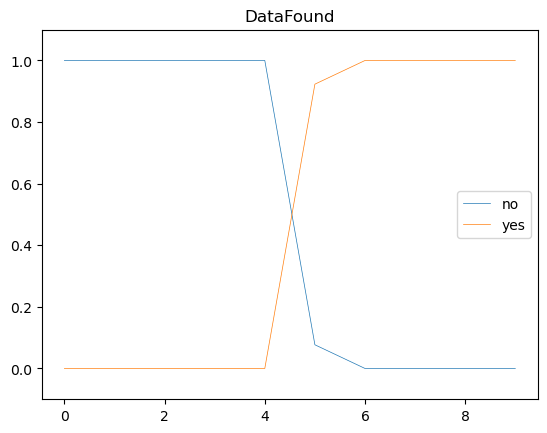

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.192399,0.807601
3,0.191957,0.808044
4,0.192399,0.807601
5,0.192220,0.807780
6,0.173193,0.826807
7,0.172248,0.827752
8,0.172260,0.827740
9,0.172260,0.827740


Plotting ('DataFound', ['no', 'yes']) for agent_j


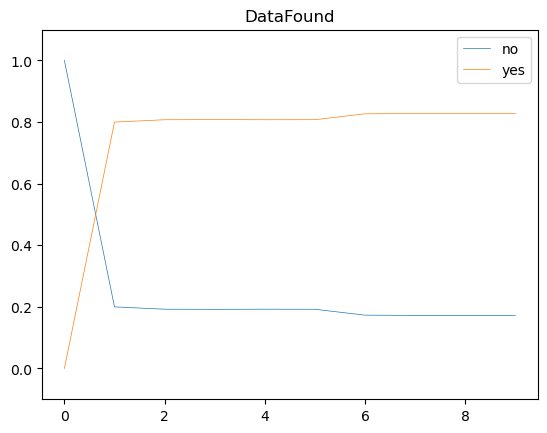

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccessLevel', ['root', 'user']) for state:


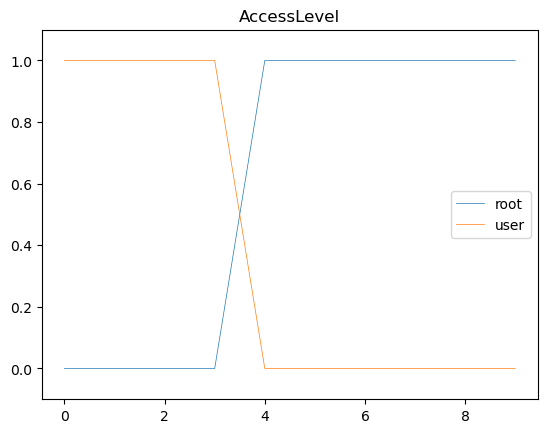

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


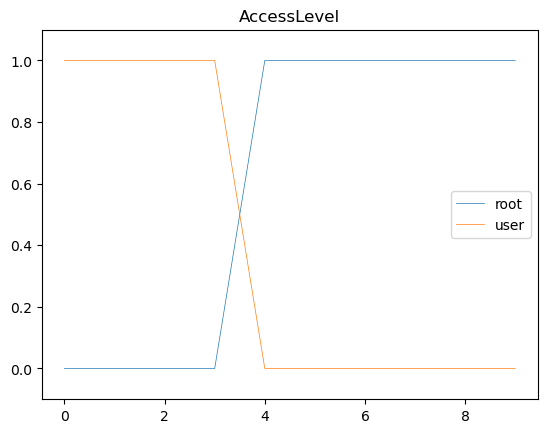

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000566,0.999434
5,0.009530,0.990470
6,0.108714,0.891286
7,0.105711,0.894289
8,0.105645,0.894355
9,0.105645,0.894355


Plotting ('AccessLevel', ['root', 'user']) for agent_j


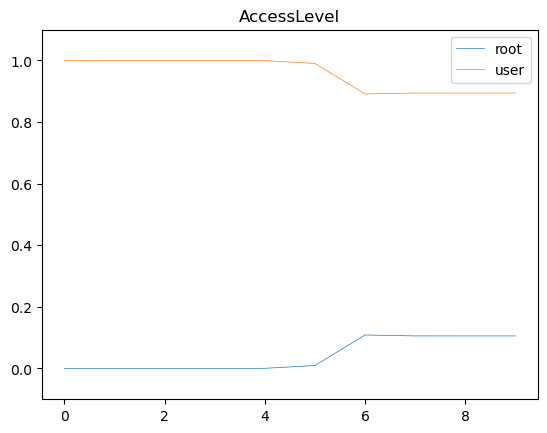

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


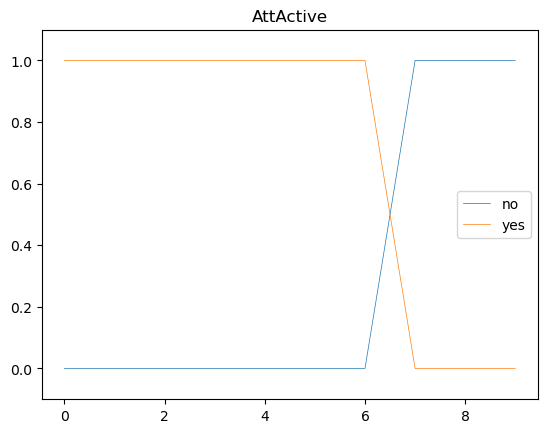

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


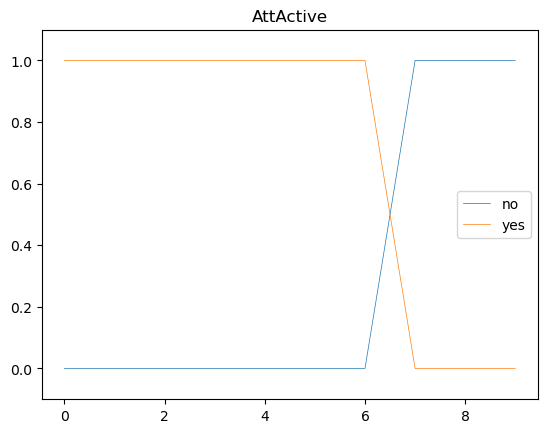

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000e+00,1.000000
1,0.000000e+00,1.000000
2,0.000000e+00,1.000000
3,2.313667e-08,1.000000
4,2.004303e-02,0.979957
5,9.808956e-01,0.019104
6,8.910835e-01,0.108917
7,9.997894e-01,0.000211
8,9.999955e-01,0.000005
9,1.000000e+00,0.000000


Plotting ('AttActive', ['no', 'yes']) for agent_j


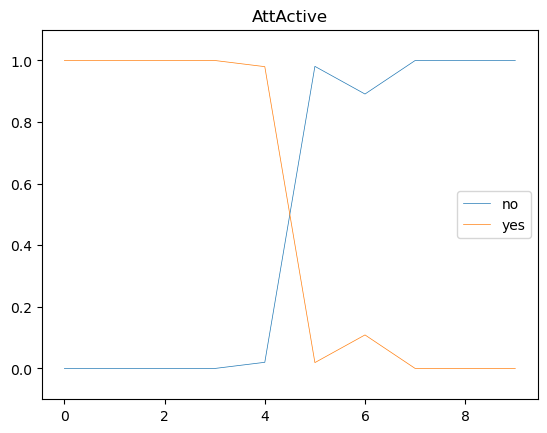

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('DataInjected', ['no', 'yes']) for state:


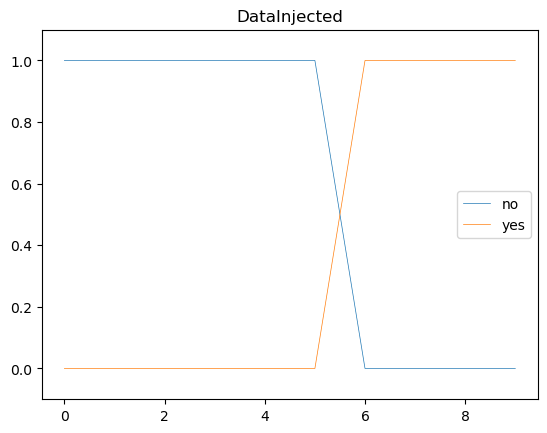

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,0.000042,0.999958
7,0.000042,0.999958
8,0.000042,0.999958
9,0.000042,0.999958


Plotting ('DataInjected', ['no', 'yes']) for agent_i


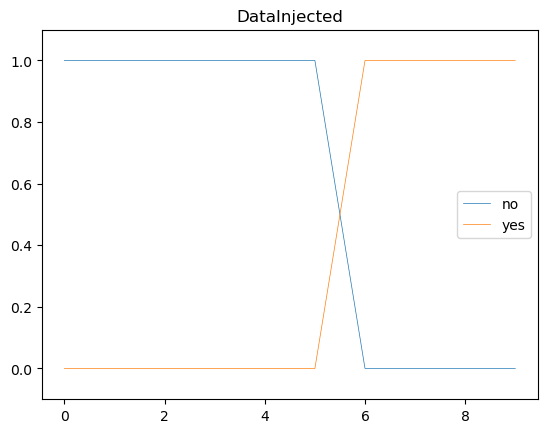

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,0.895058,0.104942
7,0.894698,0.105302
8,0.894691,0.105309
9,0.894691,0.105309


Plotting ('DataInjected', ['no', 'yes']) for agent_j


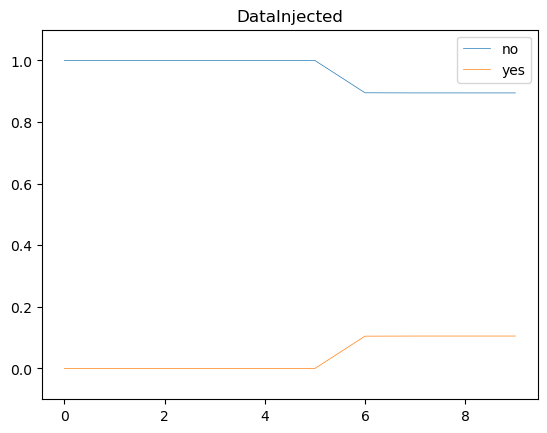

=============== End interaction trace


,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,EnumAccounts,denied|user_files|failure|active|perms_change,RestrictAccPrivs,file_write
1,EnumAccounts,denied|none|success|active|none,Nop,file_enum
2,PrivEscAcc,denied|none|failure|active|acc_policy_change,LockAccounts,login_activity
3,PrivEscAcc,auth|none|failure|active|none,Nop,login_activity
4,FileRecon,auth|user_files|success|active|none,Nop,login_activity
5,ManipulateData,auth|none|success|active|perms_change,Nop,file_write
6,Exit,denied|none|failure|terminated|none,Nop,none
7,Nop,auth|none|success|terminated|none,Nop,none
8,Nop,auth|user_files|failure|terminated|none,Nop,none
9,Nop,auth|none|success|terminated|none,Nop,none


Agent i's P(Aj)


,DecoyAccount,DeployData,LockAccounts,Nop,RestrictAccPrivs
0,0.25,0.000000,0.000000,0.000000,0.75
1,0.00,0.000000,0.000000,1.000000,0.00
2,0.00,0.000000,0.316060,0.683940,0.00
3,0.00,0.000206,0.007243,0.992551,0.00
4,0.00,0.000000,0.000000,1.000000,0.00
5,0.00,0.000000,0.000000,1.000000,0.00
6,0.00,0.000000,0.000000,1.000000,0.00
7,0.00,0.000000,0.000000,1.000000,0.00
8,0.00,0.000000,0.000000,1.000000,0.00
9,0.00,0.000000,0.000000,1.000000,0.00


Agent j's P(Aj)


,EnumAccounts,Exit,FileRecon,ManipulateData,Nop,PrivEscAcc
0,0.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000
1,0.990000,0.000000e+00,0.000000,0.010000,0.000000e+00,0.000000
2,0.000594,2.969122e-07,0.259846,0.000000,0.000000e+00,0.739561
3,0.000000,2.005399e-02,0.979718,0.000194,2.313667e-08,0.000034
4,0.000000,9.699788e-01,0.000582,0.009397,2.004303e-02,0.000000
5,0.000000,9.411592e-03,0.000153,0.000414,9.900219e-01,0.000000
6,0.000000,6.906418e-03,0.000115,0.000118,9.928597e-01,0.000000
7,0.000000,8.648146e-06,0.000000,0.000005,9.999862e-01,0.000000
8,0.000000,3.008379e-07,0.000000,0.000000,9.999997e-01,0.000000
9,0.000000,0.000000e+00,0.000000,0.000000,1.000000e+00,0.000000


,highCap,lowCap
0,0.500000,0.500000
1,0.345455,0.654545
2,0.367880,0.632120
3,0.965976,0.034024
4,1.000000,0.000000
5,1.000000,0.000000
6,1.000000,0.000000
7,1.000000,0.000000
8,1.000000,0.000000
9,1.000000,0.000000


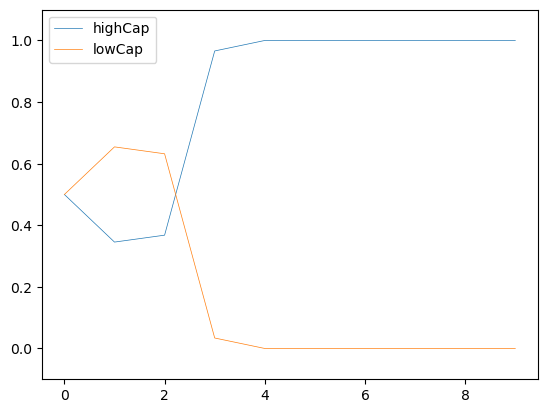

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


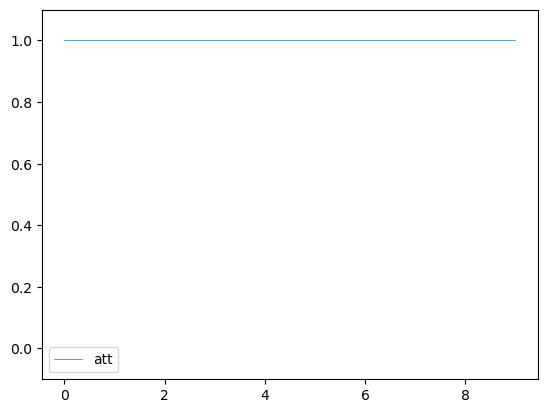

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


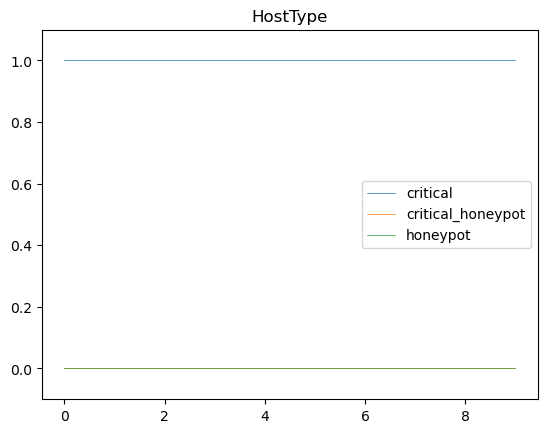

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,0.0,1.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


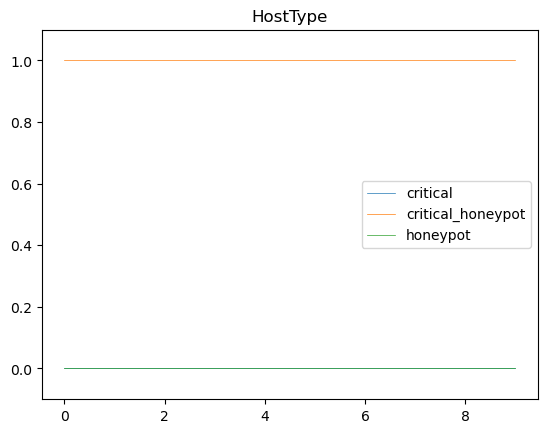

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


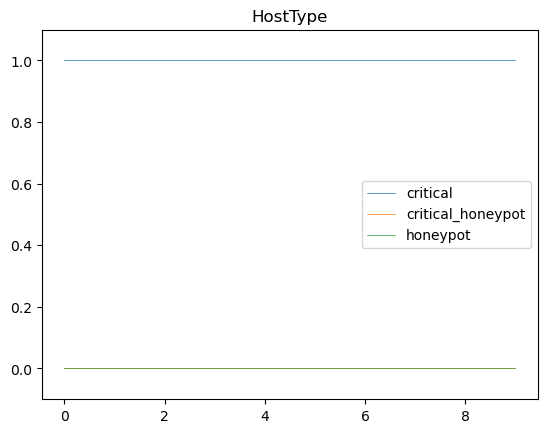

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


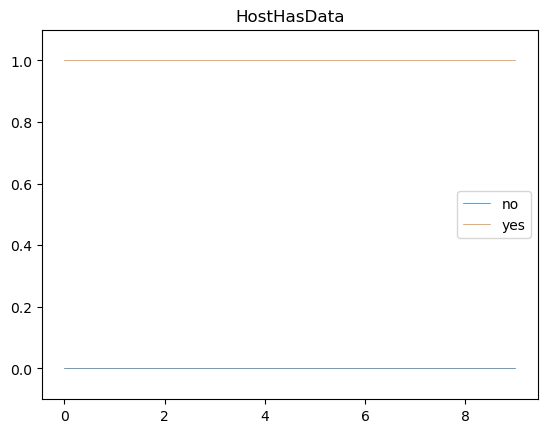

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.500000,0.500000
2,0.500000,0.500000
3,0.500000,0.500000
4,0.500000,0.500000
5,0.064103,0.935897
6,0.000035,0.999965
7,0.000035,0.999965
8,0.000035,0.999965
9,0.000035,0.999965


Plotting ('HostHasData', ['no', 'yes']) for agent_i


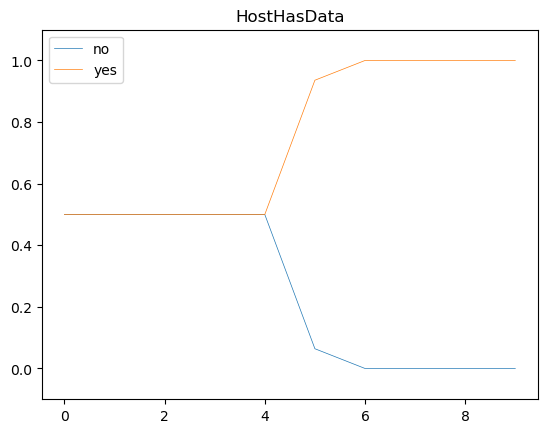

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


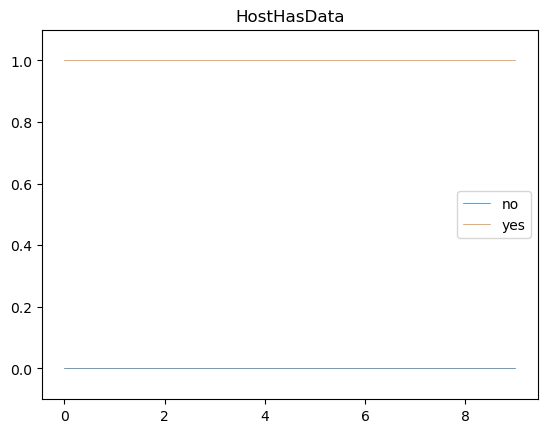

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


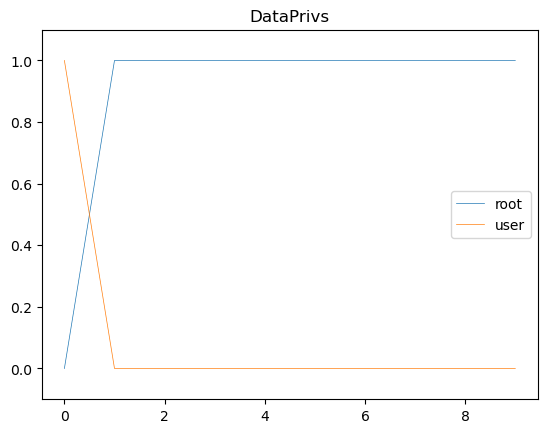

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.500000,0.500000
1,0.990909,0.009091
2,0.974090,0.025910
3,0.999891,0.000109
4,1.000000,0.000000
5,1.000000,0.000000
6,1.000000,0.000000
7,1.000000,0.000000
8,1.000000,0.000000
9,1.000000,0.000000


Plotting ('DataPrivs', ['root', 'user']) for agent_i


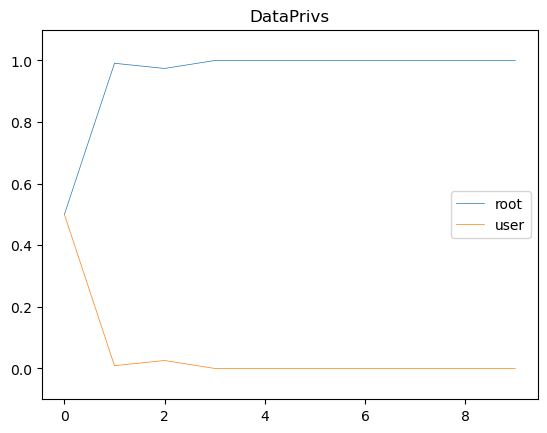

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


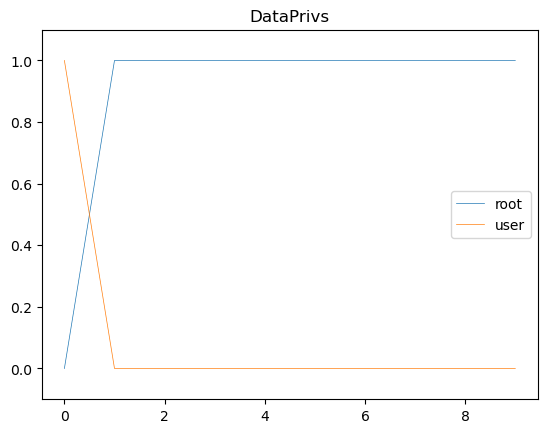

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


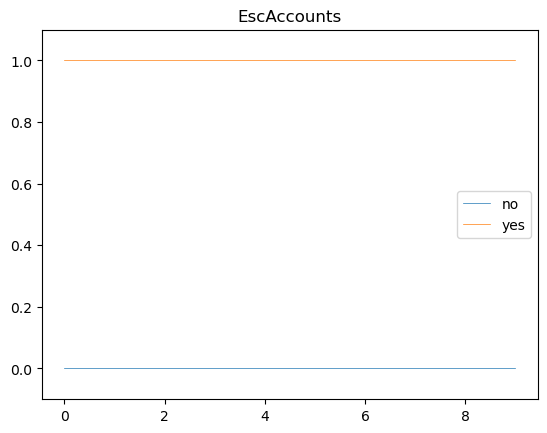

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.761755,0.238244
2,0.289079,0.710921
3,0.327154,0.672846
4,0.000000,1.000000
5,0.000000,1.000000
6,0.000000,1.000000
7,0.000000,1.000000
8,0.000000,1.000000
9,0.000000,1.000000


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


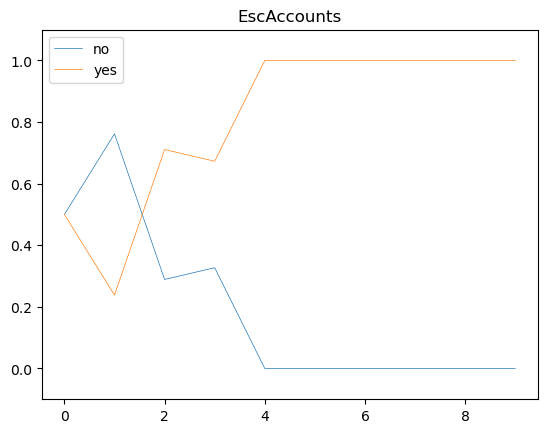

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


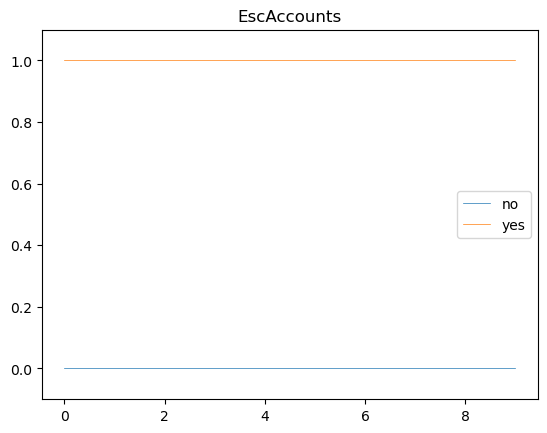

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccFound', ['no', 'yes']) for state:


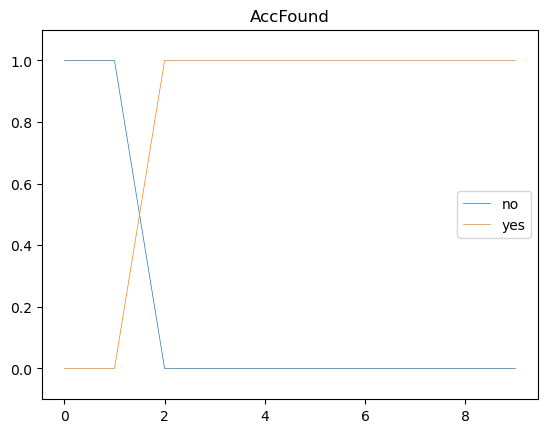

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,0.931034,0.068966
2,0.301927,0.698073
3,0.340458,0.659542
4,0.000000,1.000000
5,0.000000,1.000000
6,0.000000,1.000000
7,0.000000,1.000000
8,0.000000,1.000000
9,0.000000,1.000000


Plotting ('AccFound', ['no', 'yes']) for agent_i


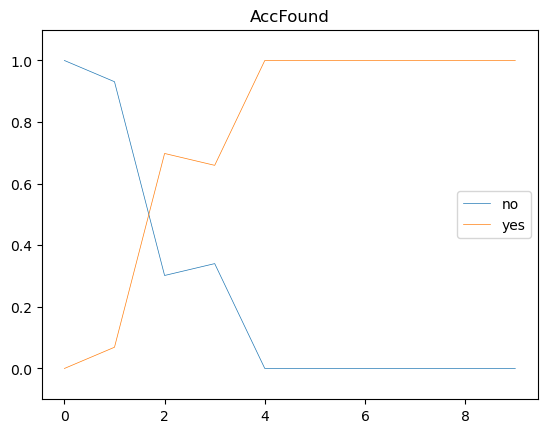

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,0.200475,0.799525
3,0.040506,0.959494
4,0.040498,0.959501
5,0.040498,0.959502
6,0.040245,0.959756
7,0.040253,0.959746
8,0.040254,0.959746
9,0.040254,0.959746


Plotting ('AccFound', ['no', 'yes']) for agent_j


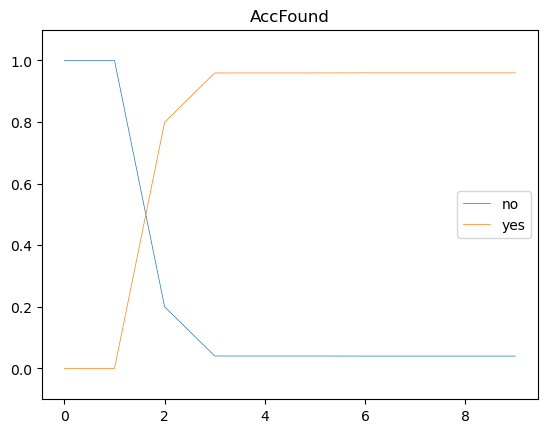

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('DataFound', ['no', 'yes']) for state:


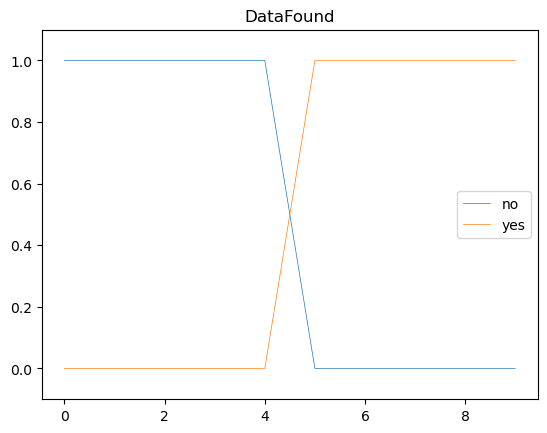

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,0.076923,0.923077
6,0.000042,0.999958
7,0.000042,0.999958
8,0.000042,0.999958
9,0.000042,0.999958


Plotting ('DataFound', ['no', 'yes']) for agent_i


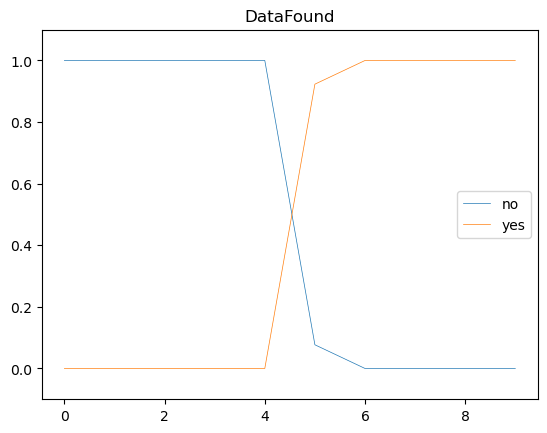

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.192399,0.807601
3,0.191957,0.808044
4,0.192399,0.807601
5,0.191946,0.808054
6,0.190701,0.809299
7,0.190643,0.809357
8,0.190644,0.809356
9,0.190644,0.809356


Plotting ('DataFound', ['no', 'yes']) for agent_j


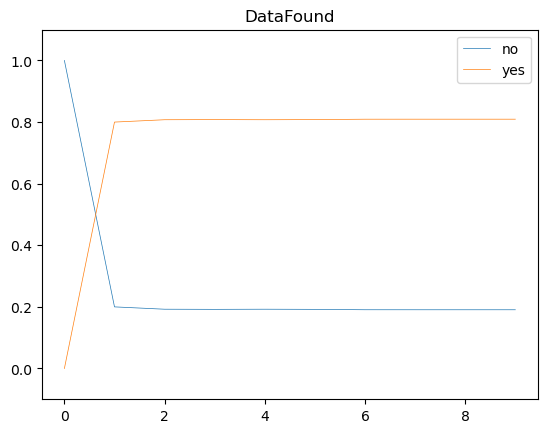

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccessLevel', ['root', 'user']) for state:


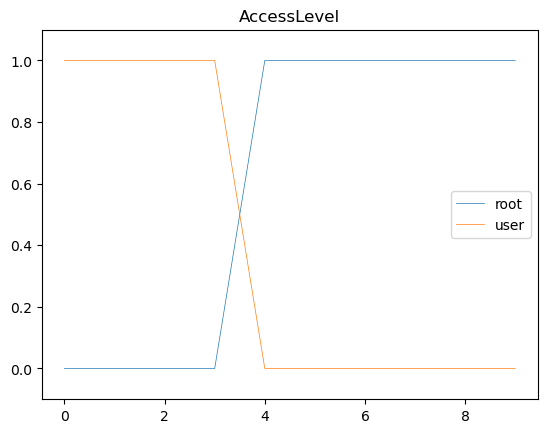

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


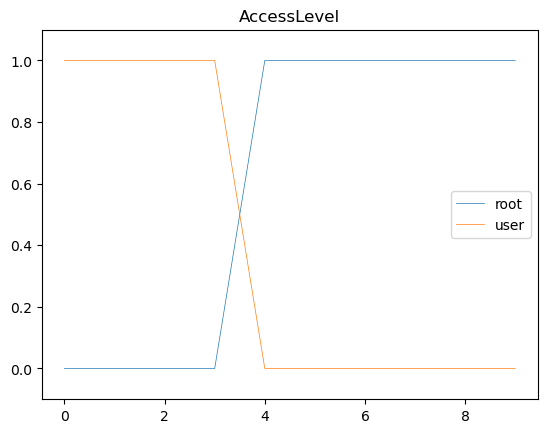

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000566,0.999434
5,0.000566,0.999434
6,0.007127,0.992873
7,0.006908,0.993092
8,0.006904,0.993096
9,0.006904,0.993096


Plotting ('AccessLevel', ['root', 'user']) for agent_j


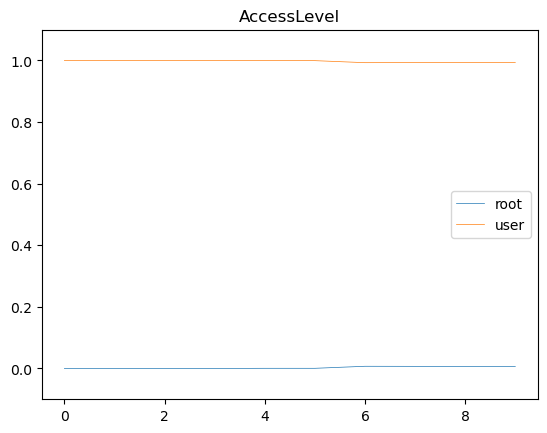

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


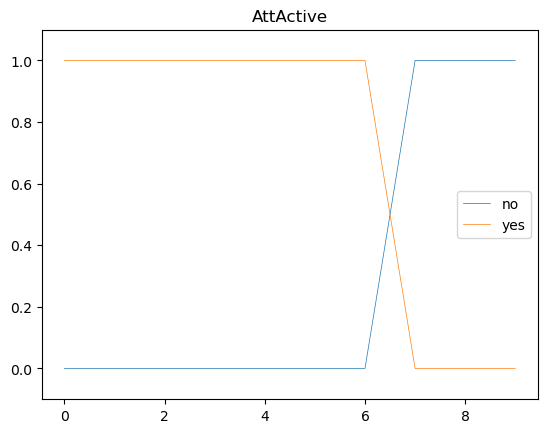

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


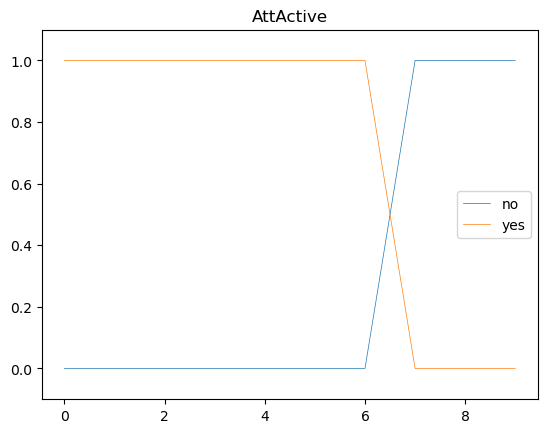

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000e+00,1.000000e+00
1,0.000000e+00,9.999999e-01
2,0.000000e+00,1.000000e+00
3,2.313667e-08,1.000000e+00
4,2.004303e-02,9.799569e-01
5,9.900219e-01,9.978170e-03
6,9.928597e-01,7.140327e-03
7,9.999862e-01,1.376236e-05
8,9.999997e-01,3.008379e-07
9,1.000000e+00,0.000000e+00


Plotting ('AttActive', ['no', 'yes']) for agent_j


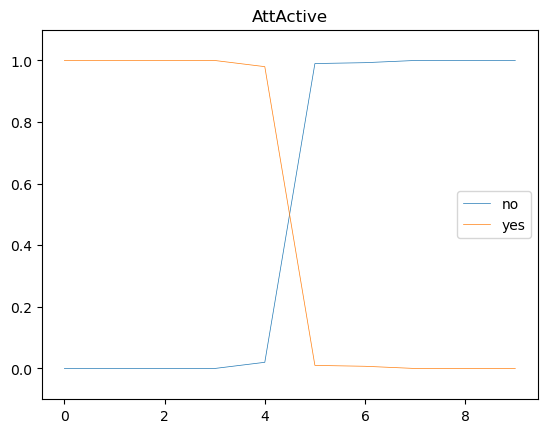

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('DataInjected', ['no', 'yes']) for state:


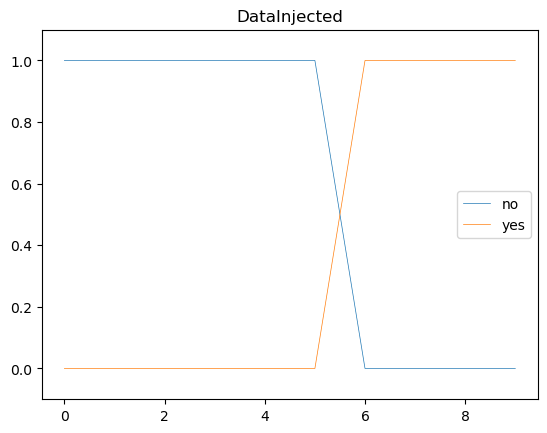

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,0.000042,0.999958
7,0.000042,0.999958
8,0.000042,0.999958
9,0.000042,0.999958


Plotting ('DataInjected', ['no', 'yes']) for agent_i


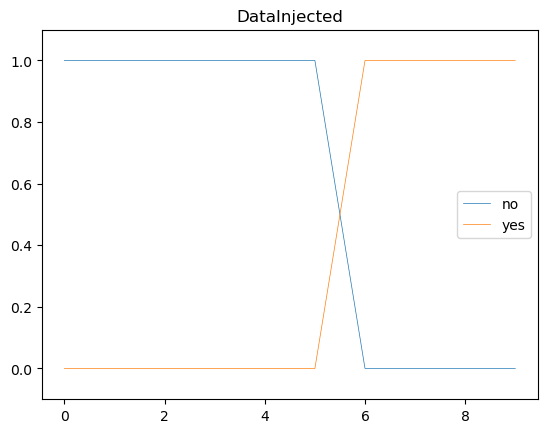

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,0.993120,0.006880
7,0.993118,0.006882
8,0.993118,0.006882
9,0.993118,0.006882


Plotting ('DataInjected', ['no', 'yes']) for agent_j


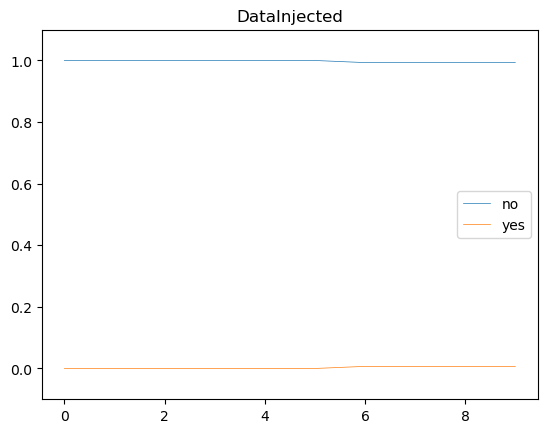

=============== End interaction trace


,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,EnumAccounts,denied|user_files|failure|active|perms_change,RestrictAccPrivs,file_enum
1,EnumAccounts,denied|user_files|success|active|none,Nop,file_enum
2,PrivEscAcc,denied|user_files|failure|active|acc_policy_ch...,LockAccounts,login_activity
3,PrivEscAcc,auth|user_files|success|active|none,Nop,login_activity
4,FileRecon,auth|none|failure|active|none,Nop,file_enum
5,FileRecon,denied|user_files|failure|active|none,Nop,login_activity
6,Exit,denied|user_files|failure|terminated|none,Nop,none
7,Nop,auth|user_files|success|terminated|none,Nop,none
8,Nop,auth|user_files|success|terminated|none,Nop,none
9,Nop,denied|none|success|terminated|none,Nop,none


Agent i's P(Aj)


,DecoyAccount,DeployData,LockAccounts,Nop,RestrictAccPrivs
0,0.25,0.000000,0.000000,0.000000,0.75
1,0.00,0.000000,0.000000,1.000000,0.00
2,0.00,0.000000,0.316060,0.683940,0.00
3,0.00,0.000206,0.007243,0.992551,0.00
4,0.00,0.000000,0.000000,1.000000,0.00
5,0.00,0.000000,0.000000,1.000000,0.00
6,0.00,0.000000,0.000000,1.000000,0.00
7,0.00,0.000000,0.000000,1.000000,0.00
8,0.00,0.000000,0.000000,1.000000,0.00
9,0.00,0.000000,0.000000,1.000000,0.00


Agent j's P(Aj)


,EnumAccounts,Exit,FileRecon,ManipulateData,Nop,PrivEscAcc
0,0.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000
1,0.990000,0.000000e+00,0.000000,0.010000,0.000000e+00,0.000000
2,0.000594,2.969122e-07,0.259846,0.000000,0.000000e+00,0.739561
3,0.000000,2.005399e-02,0.979718,0.000194,2.313667e-08,0.000034
4,0.000000,9.699788e-01,0.000582,0.009397,2.004303e-02,0.000000
5,0.000000,9.561405e-03,0.002573,0.006970,9.808956e-01,0.000000
6,0.000000,7.210950e-03,0.000324,0.002008,9.904568e-01,0.000000
7,0.000000,1.220126e-04,0.000000,0.000015,9.998624e-01,0.000000
8,0.000000,9.100580e-07,0.000000,0.000000,9.999991e-01,0.000000
9,0.000000,0.000000e+00,0.000000,0.000000,1.000000e+00,0.000000


,highCap,lowCap
0,0.500000,0.500000
1,0.345455,0.654545
2,0.367880,0.632120
3,0.965976,0.034024
4,1.000000,0.000000
5,1.000000,0.000000
6,1.000000,0.000000
7,1.000000,0.000000
8,1.000000,0.000000
9,1.000000,0.000000


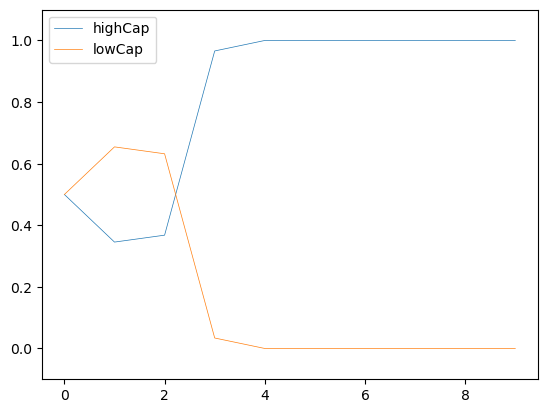

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


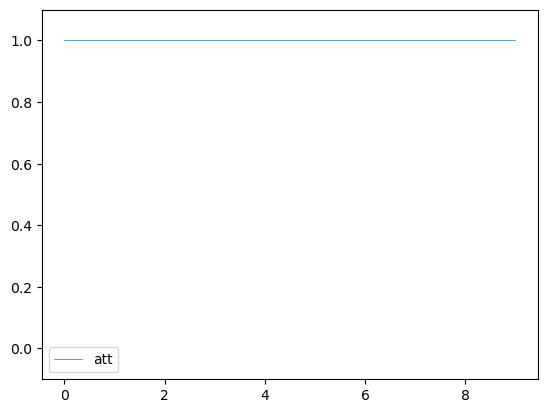

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


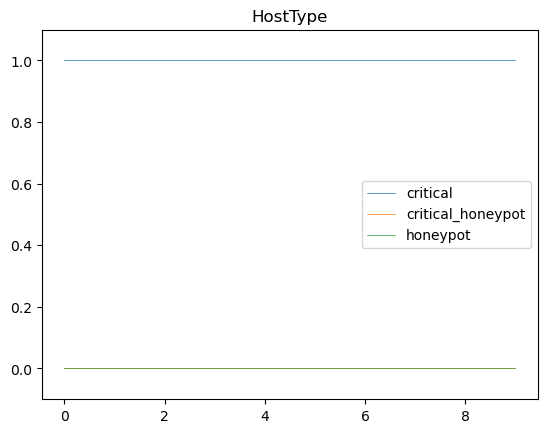

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,0.0,1.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


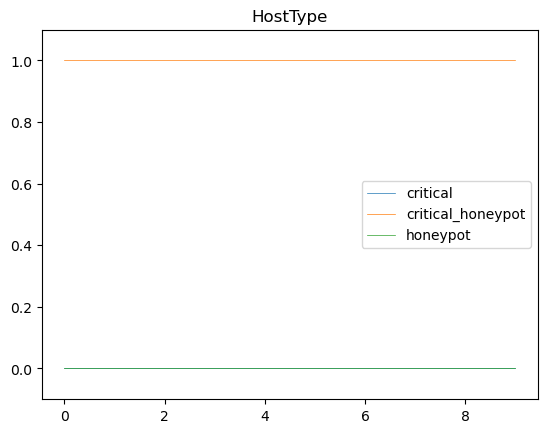

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


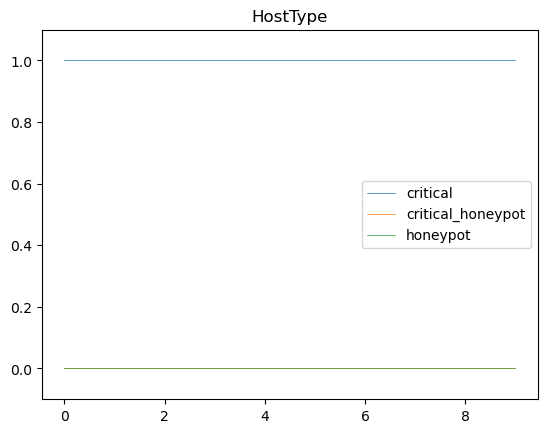

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


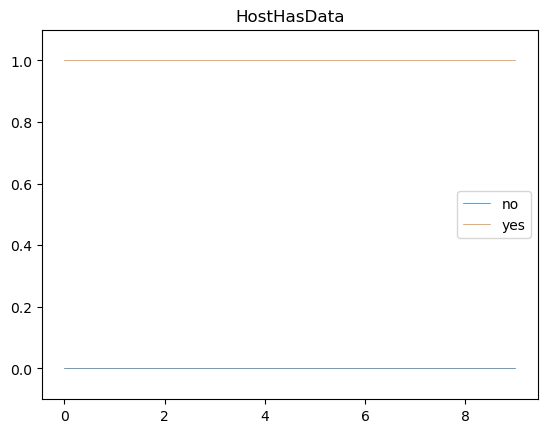

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.500000,0.500000
2,0.500000,0.500000
3,0.500000,0.500000
4,0.500000,0.500000
5,0.725807,0.274194
6,0.961538,0.038462
7,0.961539,0.038462
8,0.961538,0.038462
9,0.961539,0.038462


Plotting ('HostHasData', ['no', 'yes']) for agent_i


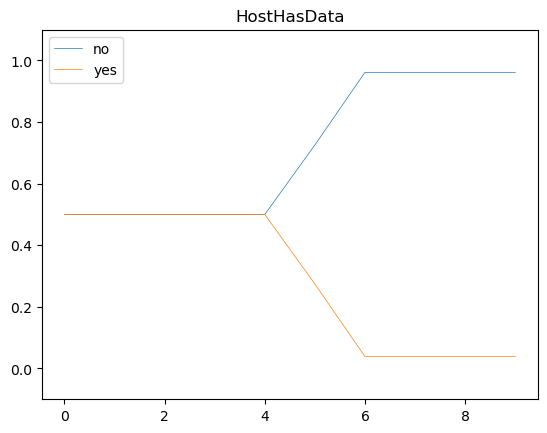

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


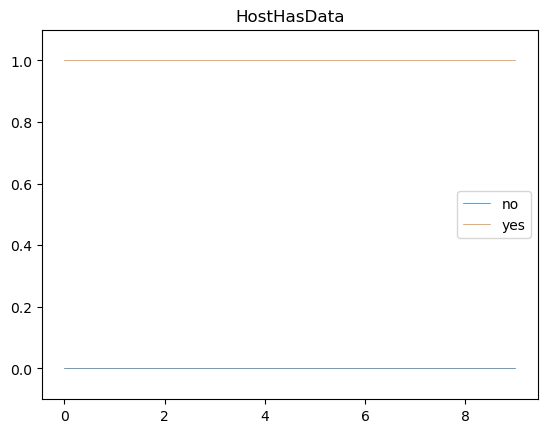

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


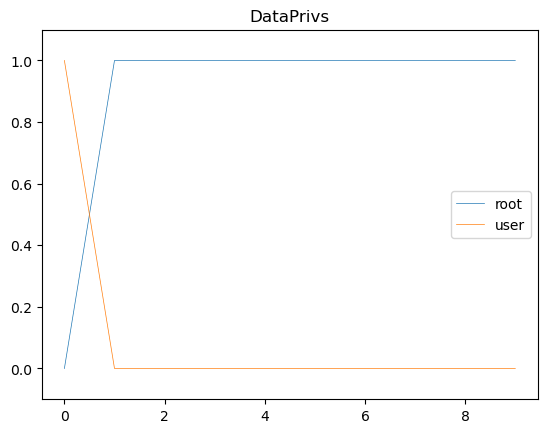

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.500000,0.500000
1,0.990909,0.009091
2,0.974090,0.025910
3,0.999891,0.000109
4,1.000000,0.000000
5,1.000000,0.000000
6,1.000000,0.000000
7,1.000000,0.000000
8,1.000000,0.000000
9,1.000000,0.000000


Plotting ('DataPrivs', ['root', 'user']) for agent_i


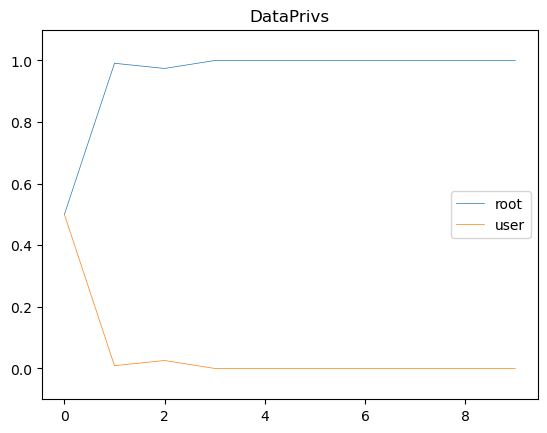

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


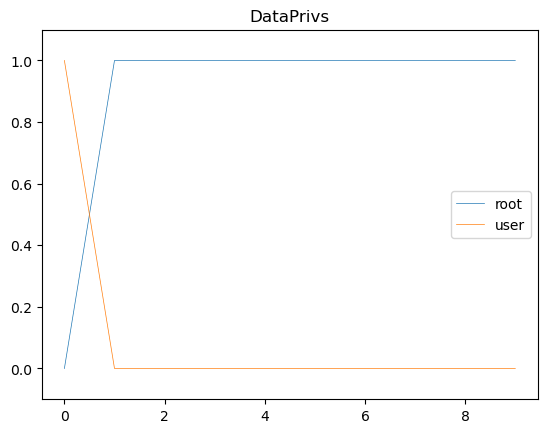

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


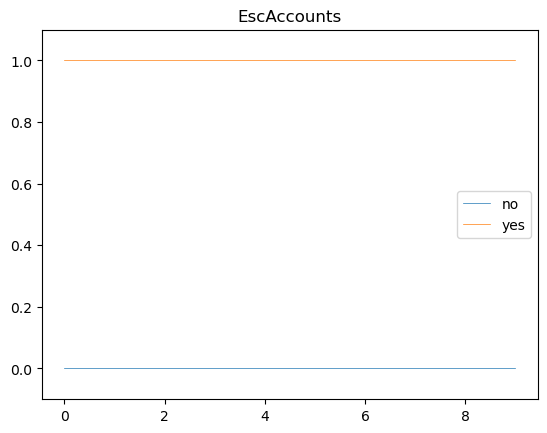

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.761755,0.238244
2,0.289079,0.710921
3,0.327154,0.672846
4,0.000000,1.000000
5,0.000000,1.000000
6,0.000000,1.000000
7,0.000000,1.000000
8,0.000000,1.000000
9,0.000000,1.000000


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


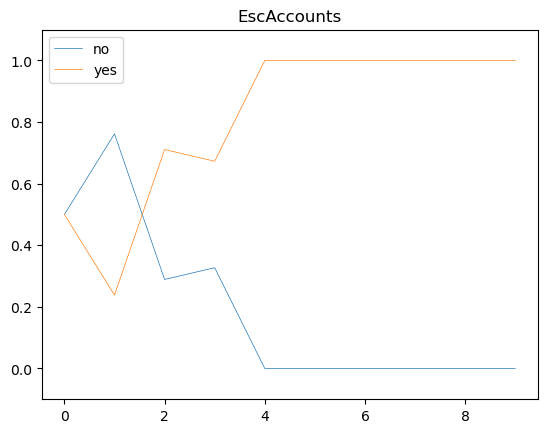

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


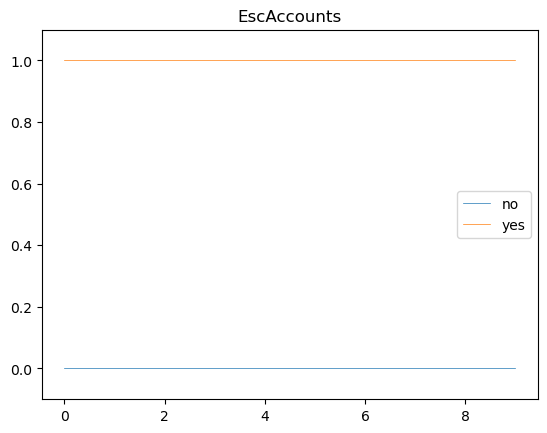

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccFound', ['no', 'yes']) for state:


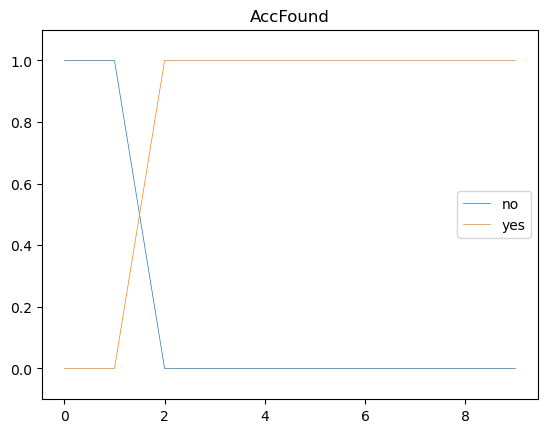

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,0.931034,0.068966
2,0.301927,0.698073
3,0.340458,0.659542
4,0.000000,1.000000
5,0.000000,1.000000
6,0.000000,1.000000
7,0.000000,1.000000
8,0.000000,1.000000
9,0.000000,1.000000


Plotting ('AccFound', ['no', 'yes']) for agent_i


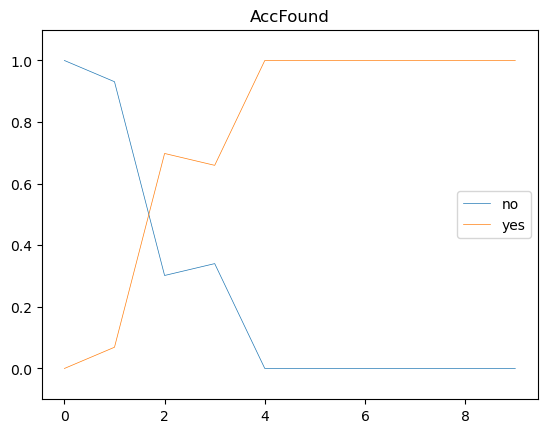

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,0.200475,0.799525
3,0.040506,0.959494
4,0.040498,0.959501
5,0.040374,0.959626
6,0.040374,0.959626
7,0.040463,0.959537
8,0.040464,0.959536
9,0.040464,0.959536


Plotting ('AccFound', ['no', 'yes']) for agent_j


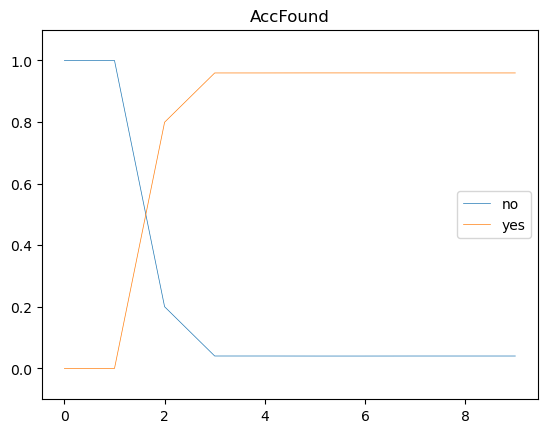

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


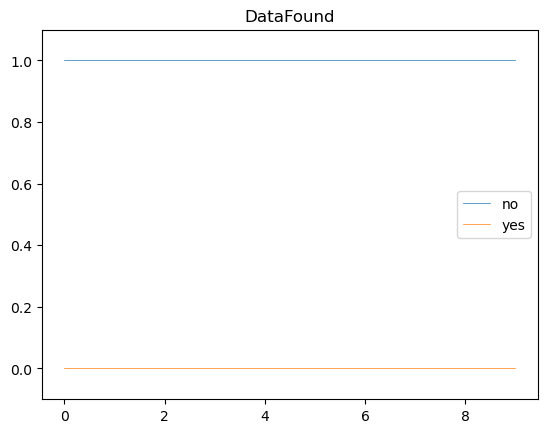

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,0.870968,0.129032
6,1.000000,0.000000
7,1.000000,0.000000
8,1.000000,0.000000
9,1.000000,0.000000


Plotting ('DataFound', ['no', 'yes']) for agent_i


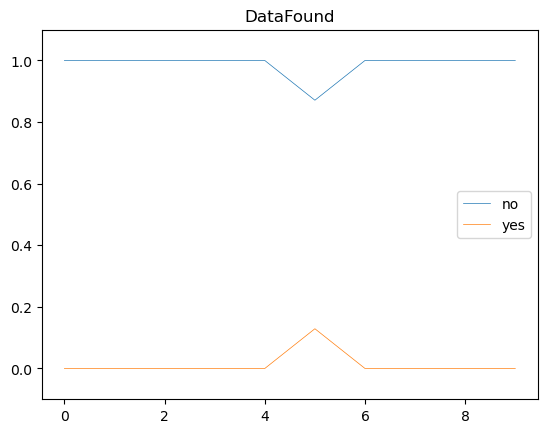

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.192399,0.807601
3,0.191957,0.808044
4,0.192399,0.807601
5,0.192220,0.807780
6,0.190771,0.809229
7,0.191003,0.808997
8,0.191006,0.808994
9,0.191006,0.808994


Plotting ('DataFound', ['no', 'yes']) for agent_j


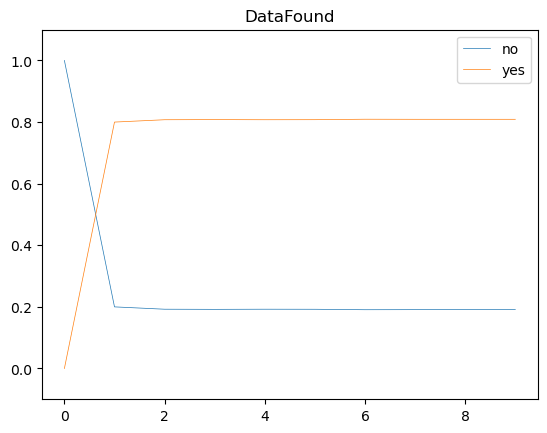

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccessLevel', ['root', 'user']) for state:


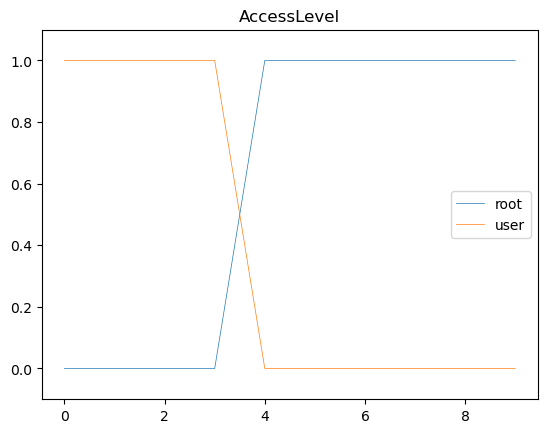

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


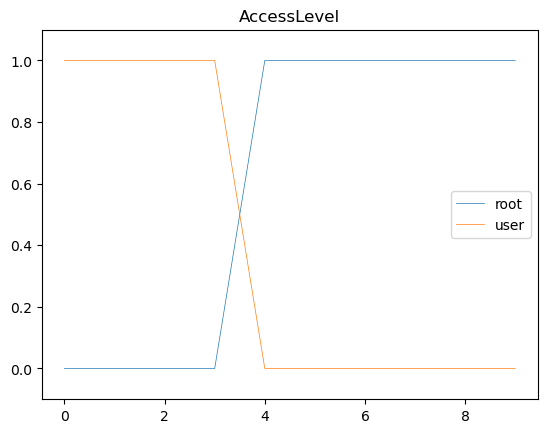

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000566,0.999434
5,0.009530,0.990470
6,0.009530,0.990470
7,0.007351,0.992649
8,0.007337,0.992663
9,0.007337,0.992663


Plotting ('AccessLevel', ['root', 'user']) for agent_j


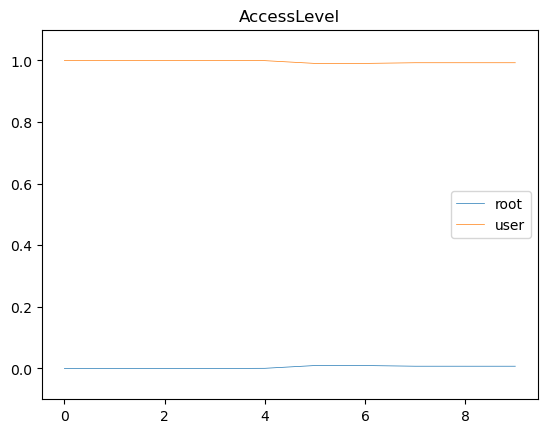

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


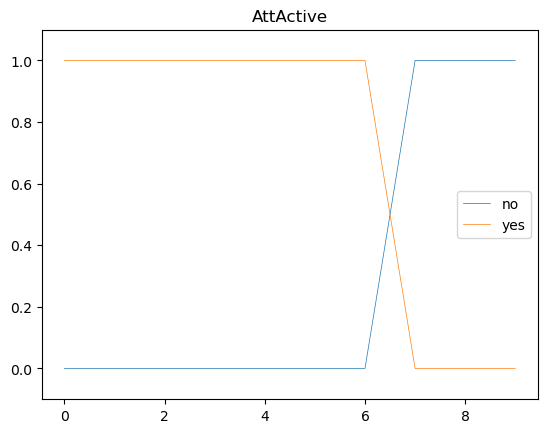

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


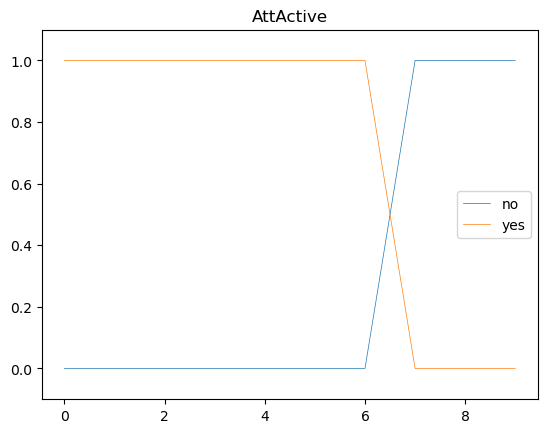

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000e+00,1.000000e+00
1,0.000000e+00,9.999999e-01
2,0.000000e+00,1.000000e+00
3,2.313667e-08,1.000000e+00
4,2.004303e-02,9.799569e-01
5,9.808956e-01,1.910444e-02
6,9.904568e-01,9.543037e-03
7,9.998624e-01,1.374833e-04
8,9.999991e-01,9.100580e-07
9,1.000000e+00,0.000000e+00


Plotting ('AttActive', ['no', 'yes']) for agent_j


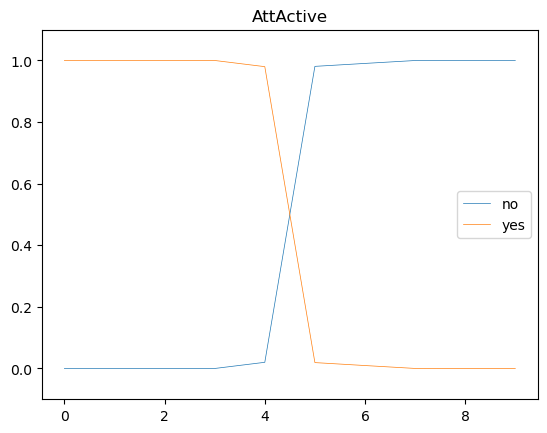

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


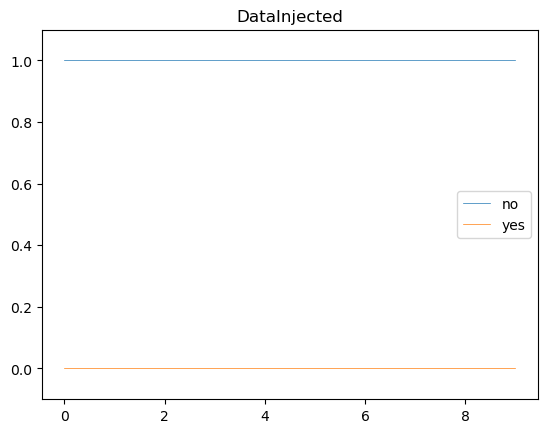

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


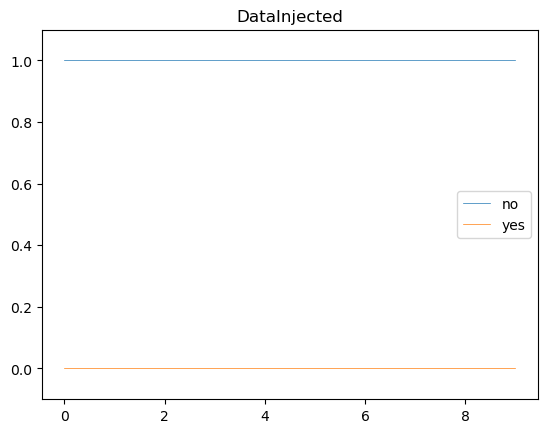

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,0.993138,0.006861
7,0.993012,0.006987
8,0.993012,0.006988
9,0.993012,0.006988


Plotting ('DataInjected', ['no', 'yes']) for agent_j


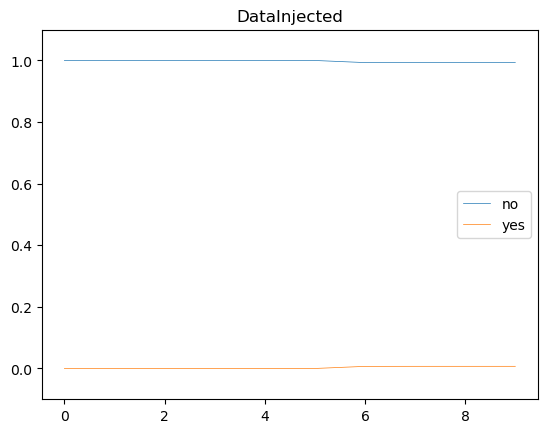

=============== End interaction trace


,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,EnumAccounts,denied|none|success|active|perms_change,RestrictAccPrivs,file_enum
1,PrivEscAcc,auth|user_files|success|active|none,Nop,login_activity
2,FileRecon,auth|user_files|success|active|acc_policy_change,LockAccounts,file_enum
3,ManipulateData,auth|none|success|active|none,Nop,file_enum
4,Exit,denied|none|success|terminated|none,Nop,none
5,Nop,denied|none|failure|terminated|none,Nop,file_write
6,Nop,denied|user_files|failure|terminated|none,Nop,file_enum
7,Nop,auth|none|failure|terminated|none,Nop,none
8,Nop,denied|none|success|terminated|none,Nop,none
9,Nop,denied|user_files|success|terminated|none,Nop,none


Agent i's P(Aj)


,DecoyAccount,DeployData,LockAccounts,Nop,RestrictAccPrivs
0,0.25,0.000000,0.000000,0.000000,0.75
1,0.00,0.000000,0.000000,1.000000,0.00
2,0.00,0.000000,0.327273,0.672727,0.00
3,0.00,0.000402,0.042632,0.956967,0.00
4,0.00,0.000117,0.000000,0.999883,0.00
5,0.00,0.000000,0.000000,1.000000,0.00
6,0.00,0.000000,0.000000,1.000000,0.00
7,0.00,0.000000,0.000000,1.000000,0.00
8,0.00,0.000000,0.000000,1.000000,0.00
9,0.00,0.000000,0.000000,1.000000,0.00


Agent j's P(Aj)


,EnumAccounts,Exit,FileRecon,ManipulateData,Nop,PrivEscAcc
0,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000
1,0.990000,0.000000,0.000000,0.010000,0.000000e+00,0.000000
2,0.009995,0.000005,0.257400,0.000000,0.000000e+00,0.732600
3,0.000000,0.821063,0.147160,0.007955,9.472713e-07,0.023821
4,0.000000,0.739269,0.007101,0.008869,2.447609e-01,0.000000
5,0.000000,0.000541,0.000111,0.000302,9.990462e-01,0.000000
6,0.000000,0.005046,0.000084,0.000087,9.947833e-01,0.000000
7,0.000000,0.000441,0.000000,0.001078,9.984813e-01,0.000000
8,0.000000,0.000063,0.000000,0.000000,9.999365e-01,0.000000
9,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000


,highCap,lowCap
0,0.500000,0.500000
1,0.345455,0.654545
2,0.345455,0.654545
3,0.900277,0.099723
4,0.896093,0.103907
5,0.896093,0.103907
6,0.896093,0.103907
7,0.896093,0.103907
8,0.896093,0.103907
9,0.896093,0.103907


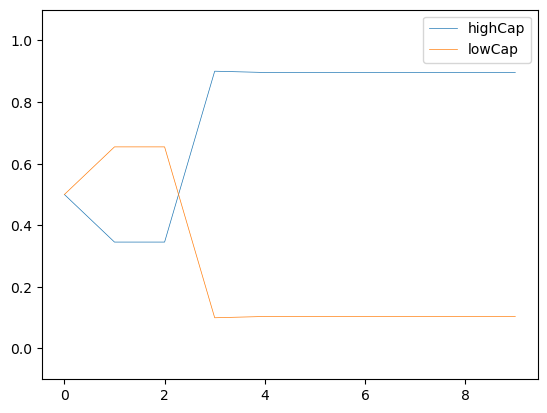

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


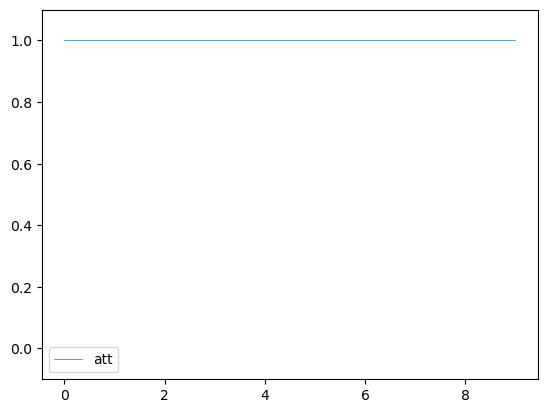

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


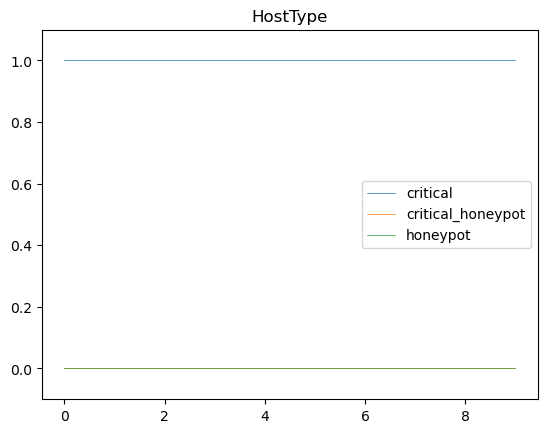

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,0.0,1.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


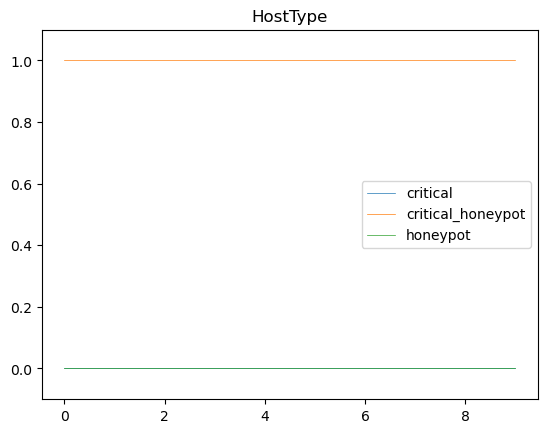

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


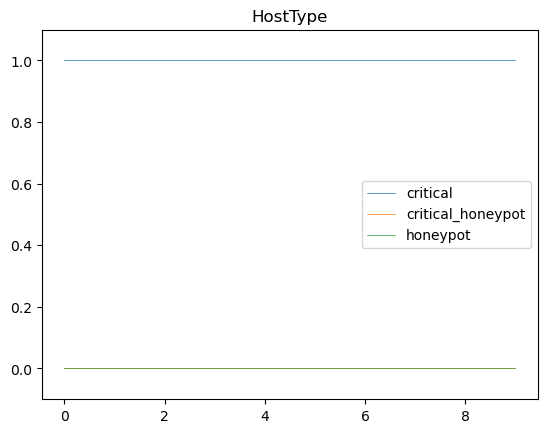

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


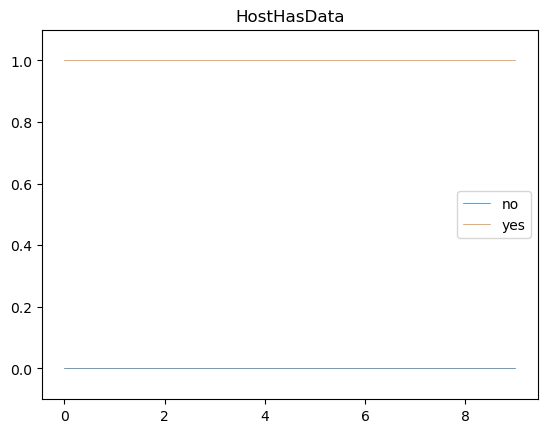

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.500000,0.500000
2,0.500000,0.500000
3,0.064103,0.935897
4,0.000035,0.999965
5,0.000035,0.999965
6,0.000035,0.999965
7,0.000035,0.999965
8,0.000035,0.999965
9,0.000035,0.999965


Plotting ('HostHasData', ['no', 'yes']) for agent_i


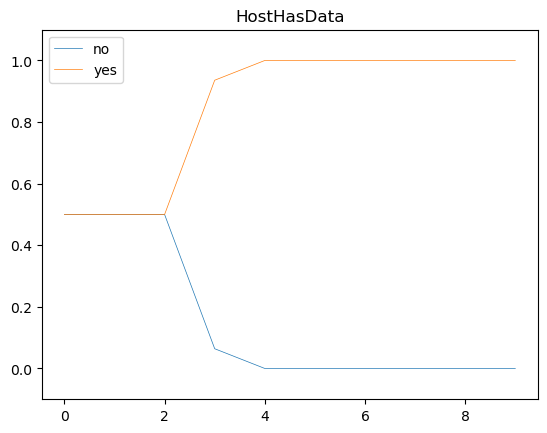

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


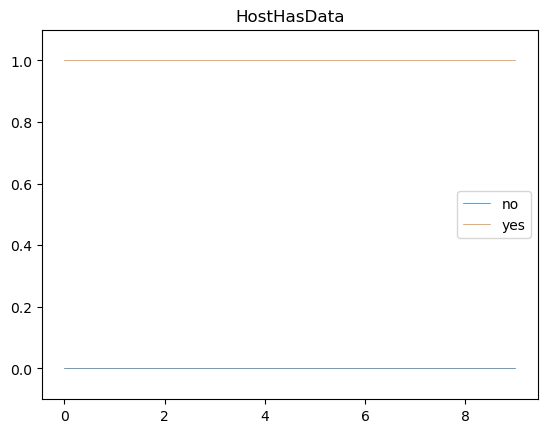

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


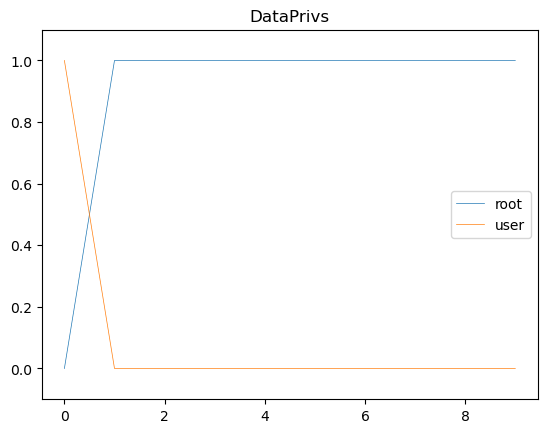

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.500000,0.500000
1,0.990909,0.009091
2,0.990909,0.009091
3,0.998615,0.001385
4,0.998557,0.001443
5,0.998557,0.001443
6,0.998557,0.001443
7,0.998557,0.001443
8,0.998557,0.001443
9,0.998557,0.001443


Plotting ('DataPrivs', ['root', 'user']) for agent_i


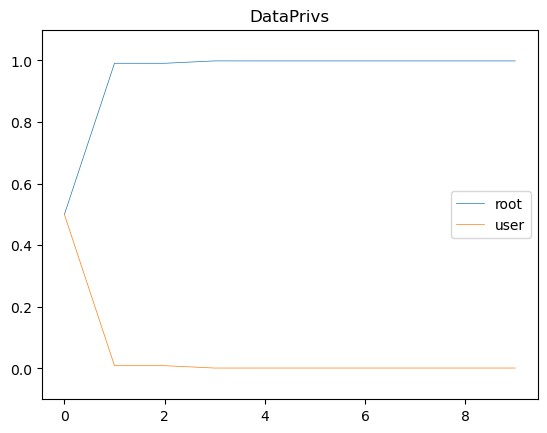

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


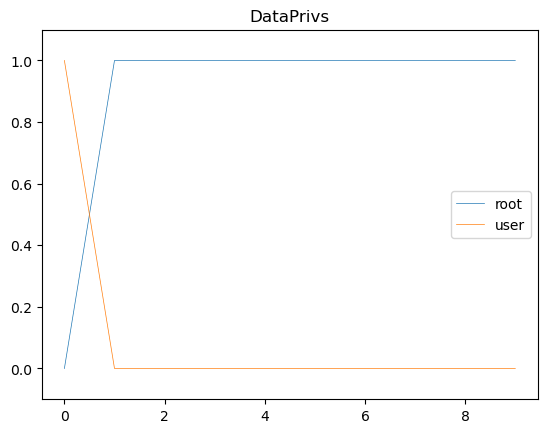

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


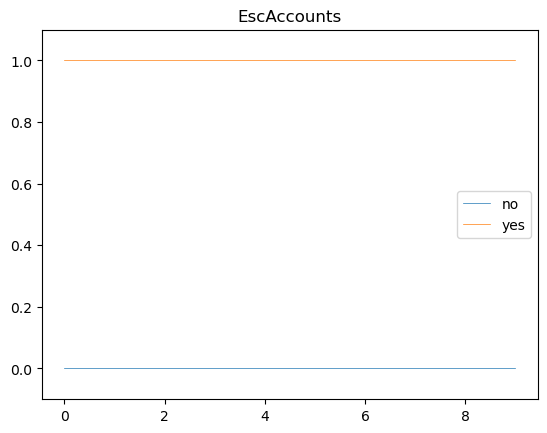

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.500000,0.500000
1,0.116883,0.883117
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000000,1.000000
5,0.000000,1.000000
6,0.000000,1.000000
7,0.000000,1.000000
8,0.000000,1.000000
9,0.000000,1.000000


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


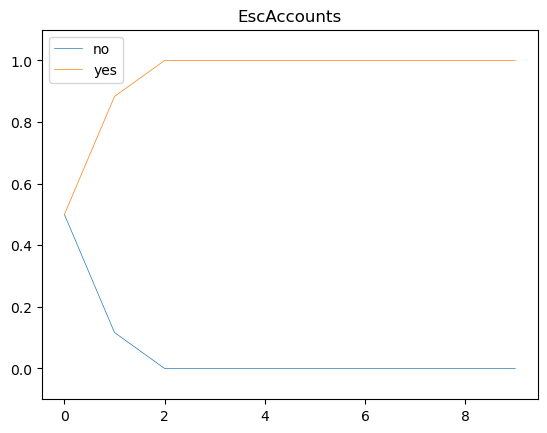

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


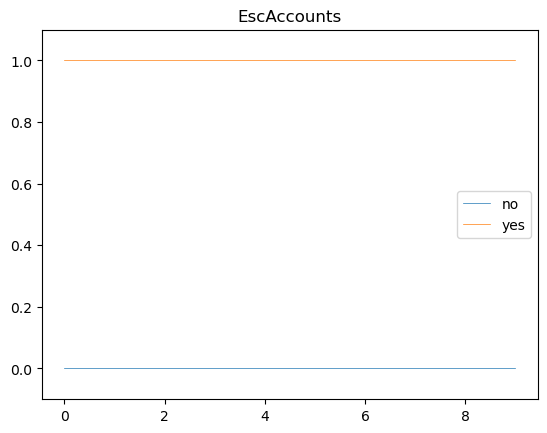

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccFound', ['no', 'yes']) for state:


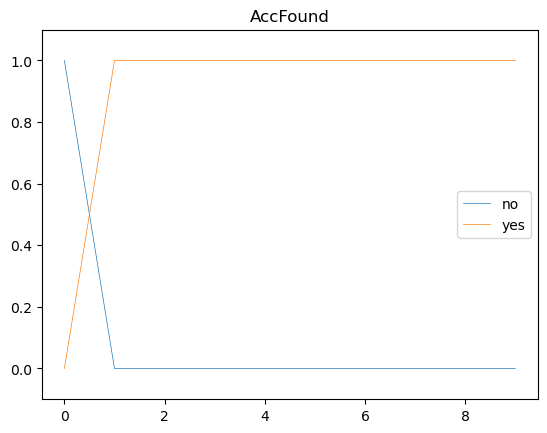

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,0.142857,0.857143
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000000,1.000000
5,0.000000,1.000000
6,0.000000,1.000000
7,0.000000,1.000000
8,0.000000,1.000000
9,0.000000,1.000000


Plotting ('AccFound', ['no', 'yes']) for agent_i


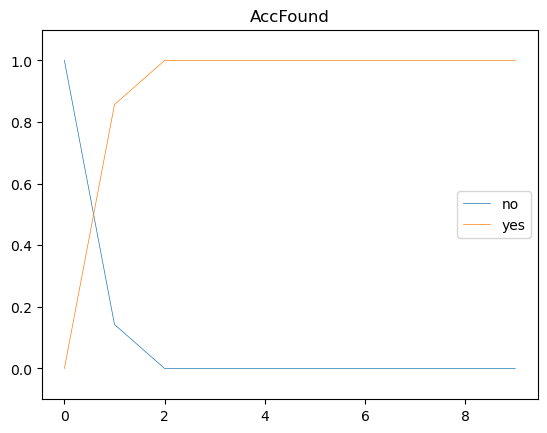

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,0.208000,0.792000
3,0.584123,0.415877
4,0.219644,0.780357
5,0.221235,0.778764
6,0.220181,0.779819
7,0.219885,0.780115
8,0.220108,0.779892
9,0.220108,0.779892


Plotting ('AccFound', ['no', 'yes']) for agent_j


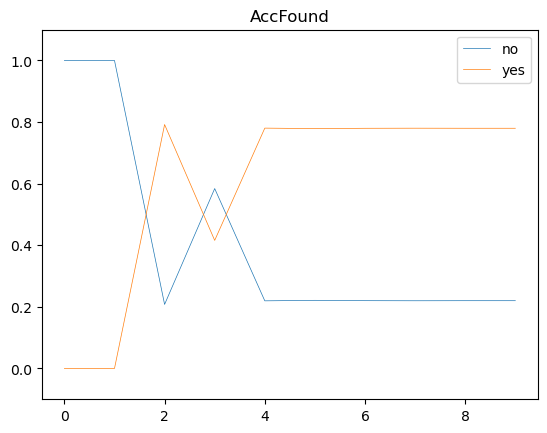

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('DataFound', ['no', 'yes']) for state:


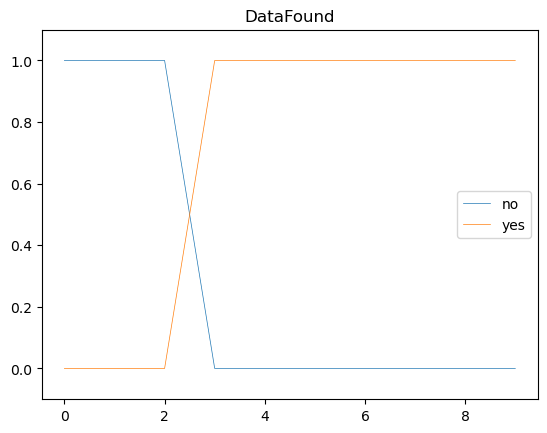

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.076923,0.923077
4,0.000042,0.999958
5,0.000042,0.999958
6,0.000042,0.999958
7,0.000042,0.999958
8,0.000042,0.999958
9,0.000042,0.999958


Plotting ('DataFound', ['no', 'yes']) for agent_i


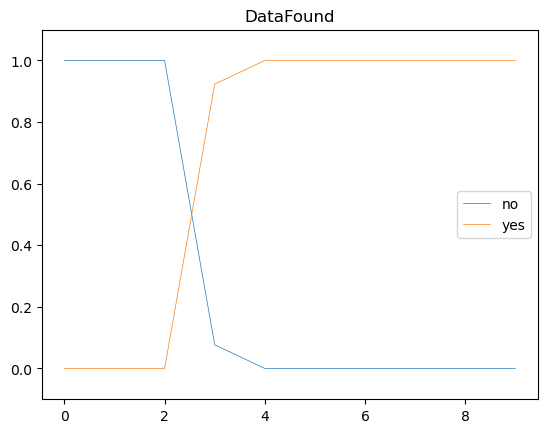

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.200000,0.800000
3,0.217933,0.782067
4,0.231917,0.768083
5,0.219865,0.780135
6,0.218821,0.781179
7,0.218701,0.781299
8,0.218912,0.781088
9,0.218912,0.781088


Plotting ('DataFound', ['no', 'yes']) for agent_j


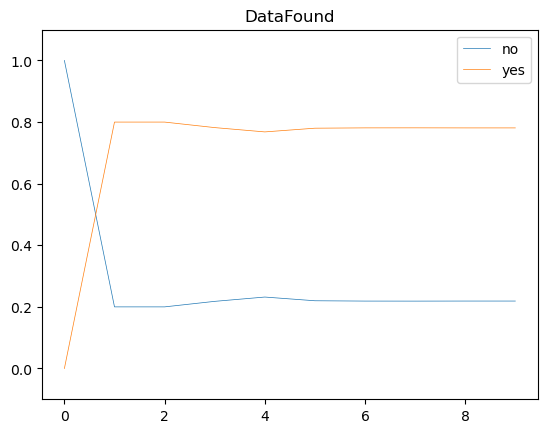

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccessLevel', ['root', 'user']) for state:


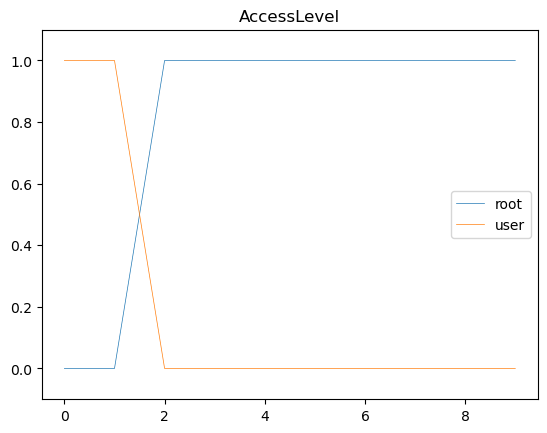

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


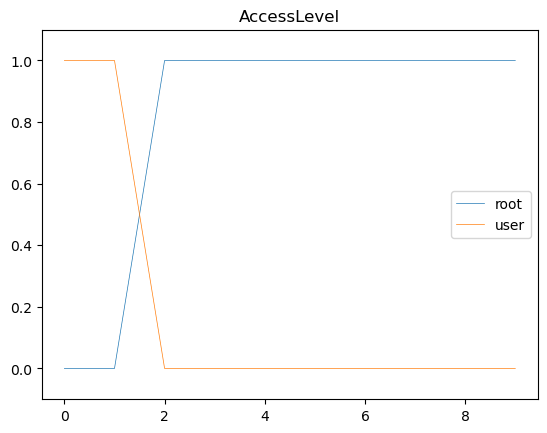

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.006909,0.993091
5,0.000413,0.999587
6,0.005207,0.994793
7,0.006548,0.993452
8,0.005539,0.994461
9,0.005539,0.994461


Plotting ('AccessLevel', ['root', 'user']) for agent_j


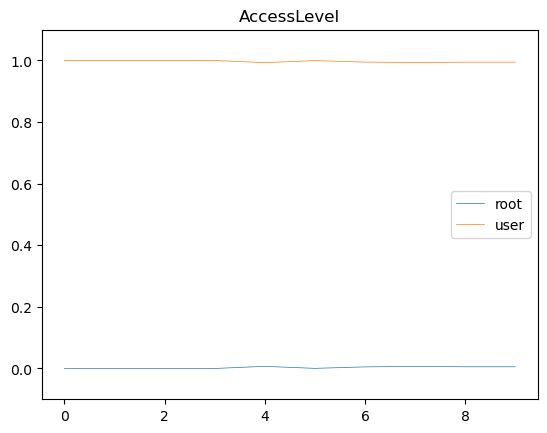

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


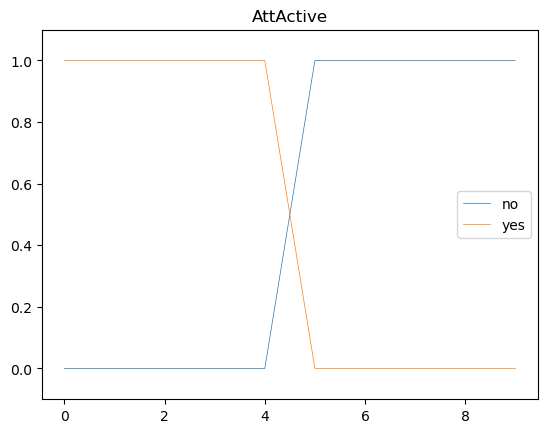

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


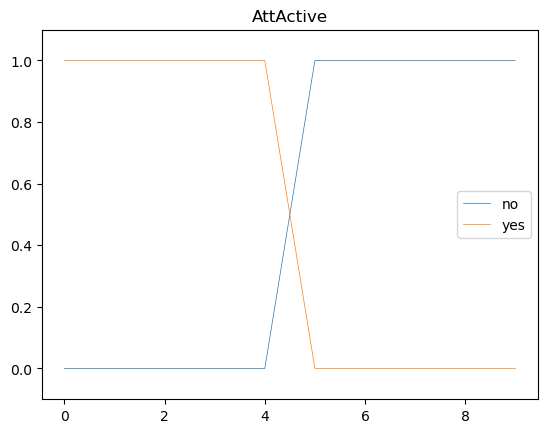

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000e+00,1.000000
1,0.000000e+00,1.000000
2,0.000000e+00,1.000000
3,9.472713e-07,0.999999
4,2.447609e-01,0.755239
5,9.990462e-01,0.000954
6,9.947833e-01,0.005217
7,9.984813e-01,0.001519
8,9.999365e-01,0.000063
9,1.000000e+00,0.000000


Plotting ('AttActive', ['no', 'yes']) for agent_j


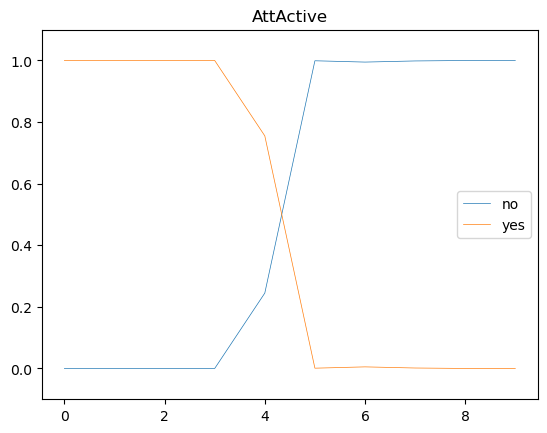

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('DataInjected', ['no', 'yes']) for state:


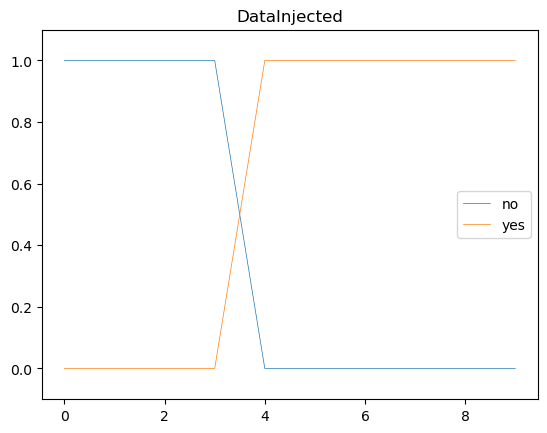

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,0.000042,0.999958
5,0.000042,0.999958
6,0.000042,0.999958
7,0.000042,0.999958
8,0.000042,0.999958
9,0.000042,0.999958


Plotting ('DataInjected', ['no', 'yes']) for agent_i


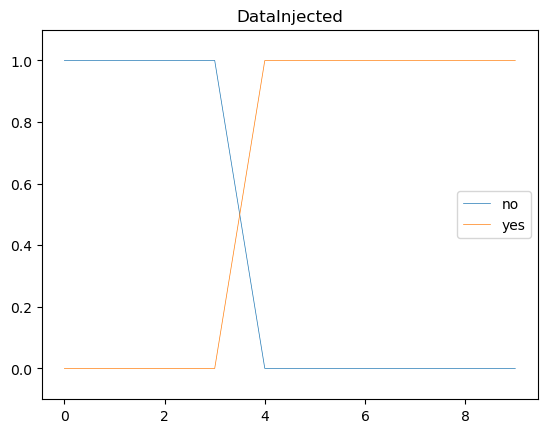

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,0.994974,0.005026
7,0.994815,0.005186
8,0.994823,0.005177
9,0.994823,0.005177


Plotting ('DataInjected', ['no', 'yes']) for agent_j


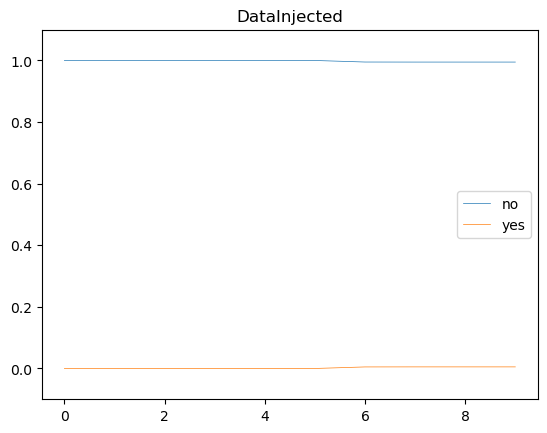

=============== End interaction trace


In [9]:
from functools import reduce

for trace in data[:5]:
    actions = summarize_interaction.pull_actions(trace)
    display(actions)
    
    try:
        frame_beliefs = summarize_interaction.pull_frame_beliefs(trace)
        
        i_PAj = summarize_interaction.pull_from_trace(trace, lambda x: x, "i_P(Aj)")
        i_PAj = list(reduce(lambda a, b: a + b, map(lambda x: list(x.values()), i_PAj)))
        i_PAj = pandas.DataFrame.from_dict(i_PAj)
        print("Agent i's P(Aj)")
        display(i_PAj)

        j_PAj = summarize_interaction.pull_from_trace(trace, lambda x: x, "j_P(Aj)")
        j_PAj = list(reduce(lambda a, b: a + b, map(lambda x: list(x.values()), j_PAj)))
        j_PAj = pandas.DataFrame.from_dict(j_PAj)
        print("Agent j's P(Aj)")
        display(j_PAj)

        for _b_theta in frame_beliefs:
            display(_b_theta)
            _b_theta.plot(linewidth=0.5)
            plotter.ylim(-0.1, 1.1)
            plotter.show()
    except Exception as e:
        print(e)
        
    for k in keys:
        beliefs = summarize_interaction.show_belief(trace, k)

        for _b in beliefs.keys():
            print(f"Showing {k} for {_b}")
            display(beliefs[_b])

            print(f"Plotting {k} for {_b}")
            beliefs[_b].plot(legend=True, title=k[0], linewidth=0.5)
            plotter.ylim(-0.1, 1.1)
            plotter.show()

    print("=============== End interaction trace")
    